## Project 4:  Solving N-Queens Problem using Genetic Algorithms

#### CSC 180  Intelligent Systems

#### Dr. Haiquan Chen, California State University, Sacramento


In [1]:
# Insert your name, your id, course title, assignment id, and due date here as comment 
# Project 4: Due 4/23
#
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239


## Part I: Position-index-based board representation

In [2]:
import random
import math
import numpy as np
# run 'pip install deap'
from deap import algorithms, base, creator, tools
board_size = 8
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [3]:
def create_individual():
    return random.sample(range(64), board_size)

In [4]:
print(create_individual())

[21, 12, 57, 61, 53, 11, 24, 38]


In [5]:
def show_grid(board, board_size):
    
    n = [0]*(board_size * board_size)
    for i in board:
        n[i] = 1
    
    count = 0
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // 8 == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print("----------------")


In [6]:
toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [7]:
pop = toolbox.population(n=1000)

print(pop[0])

[34, 12, 59, 23, 7, 38, 27, 31]


In [8]:
show_grid(pop[0], board_size)

-|-|-|-|-|-|-|X|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|X|-|-|-|X|
----------------
-|-|X|-|-|-|X|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------


### 10 pts:  Write your code in the cell below to define the "eval_fitness" function, which returns the fitness of any given board.  

- Noticed that in this case, mutation may generate invalid board, e.g., the board with dupliciate positions.  Think about   [5, 32, 8, 8, 41, 3, 55, 49]

- How to exclude those invalid boards from each generation? One way is to add some penalty to the fitness value of invalid boards.  In that case, any invalid board will have a very high fitness value (remember that our goal is to find the board with least fitness value).    To do that, let's write a function ***checkDuplicate()*** to calculate the number of queen pairs in the same position for any given board.   ***Give each duplicate a high penalty (i.e., multiply by 20, 50) and add the penalty to the fitness value.*** 

-  eval_fitness() returns the total number of duplicate position pair (with penalty) plus the total number of distinct pairs of queens that attack each other.  

In [9]:
# Calculate the number of queen pairs in the same position for any given board
def check_duplicate(individual):
    dup = 0
    individual_sorted = sorted(individual)
    duplicates=[]
    for i in individual_sorted:
     if individual_sorted.count(i)>1:
         if i not in duplicates:
             duplicates.append(i)
    dup = len(duplicates)
    
    return dup



## eval_fitness()
For a 1D array representing a board with some N queens, the following is done to check for collisions: first an empty dictionary is created. The dictionary is used to keep track of pair mappings in which an integer key maps to a tuple, representing that collision. Then, we check for a vertical, horizontal, and diagonal collision. A helper method unique_tuples() is given this dictionary, and computes a list of distinct conflicts. The size of this list is the number of distinct conflicts found for this board.

In [10]:
def unique_tuples(d):
    unique = []
    for key in d:
        reverse = ()
        item = d[key]
        for i in reversed(item):
            reverse += (i,)
        if item not in unique and reverse not in unique:
            unique.append(item)
    print(unique)
    return unique

def check_diag_right(i, j, board_size):
    n_upper = board_size + 1
    right_edge = []
    left_edge = []
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    scan_left = j
    scan_right = i
    
    # directly adjacent
    if i not in right_edge:
        right = i
        if (right + n_upper) == j:
            return True
    
    if i not in left_edge:
        left = i
        if (left - n_upper) == j:
            return True
    
    if j not in right_edge:
        right = j
        if (right + n_upper) == i:
            return True
    
    if j not in left_edge:
        left = j
        if (left - n_upper) == i:
            return True
    
    for l in range(board_size):
        if scan_left not in left_edge:
            scan_left -= n_upper
        if scan_right not in right_edge:
            scan_right += n_upper
        if scan_left == scan_right:
            return True
    return False

def check_diag_left(i, j, board_size):    
    n_lower = board_size - 1
    right_edge = []
    left_edge = []
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    scan_left = j
    scan_right = i
    
    # directly adjacent
    if i not in left_edge:
        right = i
        if (right + n_lower) == j:
            return True
    
    if i not in right_edge:
        left = i
        if (left - n_lower) == j:
            return True
    
    if j not in left_edge:
        right = j
        if (right + n_lower) == i:
            return True
    
    if j not in right_edge:
        left = j
        if (left - n_lower) == i:
            return True
    
    for l in range(board_size):
        if scan_left not in right_edge:
            scan_left -= n_lower
        if scan_right not in left_edge:
            scan_right += n_lower
        if scan_left == scan_right:
            return True
    return False

def eval_fitness(individual):
    key = 0
    pairs = {}
    sort = sorted(individual)
    n_lower = board_size - 1
    
    for i in sort: 
        for j in sort:
            if i == j:
                continue
            if (i - j) % board_size == 0:
                key += 1
                pairs[key] = (i, j)
            if (math.floor(i / board_size)) == (math.floor(j / board_size)):
                key += 1
                pairs[key] = (i, j)
            if check_diag_right(i, j, board_size): 
                key += 1
                pairs[key] = (i, j)
            if check_diag_left(i, j, board_size):
                key += 1
                pairs[key] = (i, j)
    
    unique = unique_tuples(pairs)
    return ((20*check_duplicate(individual)) + len(unique),)

In [11]:
#list1 = [0, 2, 6, 7, 7, 4, 1, 6]
#0
#8 9 10
#16 17 18 19 20 21 22 
#24 25 26 27 28 29 30 31
#32 33 34 35 36 37 38 39
#40 41 42 43 44
#48 49
#56 57 58 59 60 61 62

#  0  1  2  3  4  5  6  7
#  8  9 10 11 12 13 14 15
# 16 17 18 19 20 21 22 23
# 24 25 26 27 28 29 30 31
# 32 33 34 35 36 37 38 39
# 40 41 42 43 44 45 46 47
# 48 49 50 51 52 53 54 55
# 56 57 58 59 60 61 62 63

list1 = [0, 10, 22, 31, 39, 44, 49, 62]
list2 = [0, 2, 6, 7, 7, 4, 1, 6]
list3 = [7, 5, 2, 4, 3, 1, 3, 5]
list4 = [3, 1, 6, 0, 5, 7, 2, 1]
list5 = [7, 3, 1, 4, 5, 1, 3, 5]
print(eval_fitness(list1))
print(eval_fitness(list2))
print(eval_fitness(list3))
print(eval_fitness(list4))
print(eval_fitness(list5))
#Should print:
# [(22, 31), (22, 62), (31, 39), (44, 62)]
# (4,)

[(22, 31), (22, 62), (31, 39), (44, 62)]
(4,)
[(0, 1), (0, 2), (0, 4), (0, 6), (0, 7), (1, 2), (1, 4), (1, 6), (1, 7), (2, 4), (2, 6), (2, 7), (4, 6), (4, 7), (6, 7)]
(55,)
[(1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (2, 3), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 7), (4, 5), (4, 7), (5, 7)]
(55,)
[(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 5), (1, 6), (1, 7), (2, 3), (2, 5), (2, 6), (2, 7), (3, 5), (3, 6), (3, 7), (5, 6), (5, 7), (6, 7)]
(41,)
[(1, 3), (1, 4), (1, 5), (1, 7), (3, 4), (3, 5), (3, 7), (4, 5), (4, 7), (5, 7)]
(70,)


In [12]:
show_grid(pop[0], board_size)
print(eval_fitness(pop[0]))

-|-|-|-|-|-|-|X|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|X|-|-|-|X|
----------------
-|-|X|-|-|-|X|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
[(7, 23), (7, 31), (23, 31), (27, 31), (27, 34), (27, 59), (31, 38), (31, 59), (34, 38)]
(9,)


In [13]:
print(check_duplicate(pop[0]))

0


### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [14]:

toolbox.register("evaluate", eval_fitness)


In [15]:
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 63, indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)

In [16]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

In [17]:
stats.register("avg", np.mean)
stats.register("min", np.min)

### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change.

#### The *simple evolutionary algorithm* takes 5 arguments, a population, a toolbox, a probability of cross-overing two individuals (`cxpb`), a probability of mutating each individual (`mutpb`) and a number of generations to accomplish (`ngen`). 

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)

[(4, 22), (4, 60), (22, 29), (22, 31), (27, 29), (27, 31), (27, 43), (29, 31), (29, 43), (29, 47), (31, 47), (43, 47)]
[(2, 10), (2, 26), (2, 50), (10, 15), (10, 26), (10, 50), (15, 39), (26, 35), (26, 50), (35, 39)]
[(29, 30), (29, 37), (30, 37), (30, 54), (30, 58), (48, 52), (48, 54), (52, 54)]
[(4, 11), (4, 28), (10, 11), (10, 15), (10, 26), (10, 28), (11, 15), (26, 28), (28, 37)]
[(9, 41), (29, 38), (32, 38), (32, 41), (38, 62), (41, 59), (51, 59), (59, 62)]
[(20, 23), (20, 52), (23, 63), (26, 42), (42, 43), (42, 46), (43, 46), (43, 52)]
[(0, 1), (1, 10), (1, 25), (1, 37), (10, 13), (13, 22), (13, 37), (13, 53), (37, 53)]
[(10, 14), (10, 24), (10, 28), (10, 46), (14, 28), (14, 46), (24, 25), (24, 28), (24, 31), (25, 28), (25, 31), (28, 31), (28, 35), (28, 46)]
[(22, 23), (23, 51), (23, 55), (24, 56), (34, 41), (51, 55)]
[(18, 32), (18, 36), (18, 54), (32, 36), (32, 38), (32, 48), (36, 38), (36, 54), (38, 54), (48, 51), (48, 54), (51, 54), (51, 59)]
[(13, 15), (13, 27), (13, 29), (1

[(2, 5), (2, 7), (5, 7), (5, 21), (7, 21), (7, 39), (21, 39), (41, 48), (41, 57), (48, 57)]
[(6, 38), (28, 60), (60, 63)]
[(23, 30), (26, 30), (26, 40), (30, 38), (32, 38), (32, 40), (38, 52)]
[(13, 14), (14, 38), (18, 34), (34, 35), (34, 38), (35, 38), (35, 49), (38, 47)]
[(16, 22), (16, 32), (16, 34), (22, 50), (32, 34), (32, 50), (34, 50), (60, 61), (60, 63), (61, 63)]
[(20, 22), (20, 52), (22, 31), (22, 54), (26, 31), (26, 40), (31, 45), (40, 45), (45, 52), (45, 54), (52, 54)]
[(7, 23), (7, 39), (23, 39), (29, 38), (29, 45), (29, 61), (38, 39), (38, 45), (38, 54), (45, 54), (45, 61), (54, 61)]
[(0, 24), (0, 36), (13, 53), (24, 28), (24, 33), (28, 35), (28, 36), (33, 35), (33, 36), (35, 36), (35, 53)]
[(3, 12), (3, 43), (12, 13), (43, 47)]
[(4, 13), (8, 13), (8, 26), (8, 48), (13, 27), (26, 27), (27, 59)]
[(18, 22), (18, 32), (32, 37), (37, 44), (44, 47), (47, 63), (57, 63)]
[(4, 12), (4, 18), (10, 12), (10, 15), (10, 18), (10, 46), (12, 15), (15, 29)]
[(16, 25), (25, 27), (25, 28),

[(2, 4), (2, 16), (2, 38), (4, 22), (16, 22), (16, 48), (22, 38), (38, 45), (45, 59)]
[(3, 11), (3, 19), (8, 11), (8, 16), (11, 19), (16, 19), (49, 54)]
[(3, 4), (3, 6), (3, 10), (3, 12), (4, 6), (4, 12), (4, 22), (6, 22), (6, 62), (10, 12), (22, 62), (57, 62)]
[(6, 15), (6, 20), (10, 15), (15, 31), (31, 45), (45, 61)]
[(2, 16), (2, 58), (14, 15), (14, 56), (16, 24), (16, 56), (24, 56), (51, 58), (56, 58)]
[(1, 5), (1, 10), (5, 53), (53, 60)]
[(3, 21), (3, 35), (16, 21), (16, 22), (16, 24), (21, 22), (21, 35), (21, 53), (35, 44), (35, 53), (44, 53)]
[(18, 26), (18, 42), (26, 28), (26, 42), (28, 37), (28, 42), (28, 52), (42, 47), (48, 52)]
[(9, 13), (13, 29), (13, 53), (28, 29), (28, 42), (29, 38), (29, 47), (29, 53), (38, 47), (42, 47)]
[(2, 11), (8, 11), (8, 32), (8, 44), (28, 37), (28, 44), (28, 52), (32, 37), (37, 44), (44, 52)]
[(2, 7), (28, 36), (33, 36), (33, 40), (36, 43), (40, 43), (40, 48)]
[(10, 12), (10, 15), (12, 15), (12, 52), (15, 47), (47, 61), (51, 52), (51, 59), (52, 5

[(3, 6), (6, 34), (28, 37), (34, 37), (37, 45), (37, 53), (45, 53)]
[(4, 52), (4, 60), (27, 29), (27, 30), (27, 31), (27, 51), (29, 30), (29, 31), (30, 31), (51, 52), (51, 60), (52, 60)]
[(1, 3), (1, 55), (16, 18), (16, 23), (18, 23), (18, 50), (23, 55), (50, 53), (50, 55), (53, 55)]
[(2, 5), (2, 18), (5, 12), (5, 19), (12, 19), (18, 19), (19, 43)]
[(0, 2), (0, 7), (0, 18), (0, 40), (2, 7), (2, 18), (2, 26), (7, 55), (18, 26), (26, 40)]
[(10, 26), (16, 40), (26, 40), (39, 63), (60, 63)]
[(1, 3), (1, 4), (1, 19), (3, 4), (3, 19), (3, 59), (4, 20), (4, 60), (19, 20), (19, 59), (20, 60), (59, 60)]
[(2, 6), (2, 18), (2, 38), (6, 38), (18, 23), (18, 36), (23, 63), (36, 38), (56, 63)]
[(10, 24), (10, 26), (16, 21), (16, 24), (21, 45), (24, 26), (41, 45)]
[(0, 8), (0, 36), (0, 48), (8, 48), (36, 50), (36, 52), (48, 49), (48, 50), (48, 52), (49, 50), (49, 52), (50, 52), (52, 61)]
[(3, 27), (3, 39), (3, 51), (3, 59), (27, 31), (27, 51), (27, 59), (31, 39), (31, 55), (31, 59), (39, 55), (51, 55)

[(35, 37), (35, 39), (35, 43), (35, 49), (37, 39), (40, 43), (40, 49), (43, 52), (49, 52)]
[(6, 13), (6, 48), (6, 62), (32, 33), (32, 48), (60, 62)]
[(8, 15), (8, 16), (8, 56), (15, 43), (15, 57), (16, 56), (35, 43), (43, 57), (56, 57)]
[(20, 48), (20, 52), (25, 30), (25, 57), (48, 52), (48, 56), (48, 57), (56, 57)]
[(3, 6), (3, 43), (6, 48), (9, 18), (9, 33), (18, 26), (26, 33)]
[(9, 16), (9, 41), (9, 63), (16, 23), (16, 24), (16, 48), (16, 52), (23, 63), (24, 48), (41, 48), (48, 52)]
[(5, 7), (5, 29), (7, 35), (29, 36), (32, 35), (32, 36), (32, 41), (35, 36), (35, 42), (41, 42)]
[(5, 13), (5, 21), (5, 45), (13, 15), (13, 21), (13, 31), (13, 41), (13, 45), (15, 31), (21, 45), (31, 45), (41, 45), (45, 54)]
[(1, 55), (11, 20), (20, 34), (20, 52), (31, 55), (34, 50), (34, 52), (50, 52), (50, 55), (52, 55)]
[(6, 15), (6, 34), (10, 15), (10, 24), (10, 34), (15, 39), (15, 43), (24, 32), (32, 34), (32, 39), (34, 39), (34, 43)]
[(0, 3), (0, 18), (0, 32), (3, 19), (18, 19), (18, 23), (18, 32),

[(8, 10), (8, 24), (10, 24), (21, 23), (21, 29), (23, 47), (23, 55), (24, 29), (29, 47), (47, 55)]
[(23, 30), (24, 25), (24, 30), (24, 40), (24, 56), (25, 30), (25, 57), (40, 56), (56, 57)]
[(12, 20), (12, 21), (20, 21), (20, 22), (20, 23), (21, 22), (21, 23), (22, 23), (22, 31), (22, 62), (23, 31)]
[(21, 29), (21, 61), (25, 29), (25, 43), (25, 57), (25, 61), (29, 43), (29, 57), (29, 61), (43, 51), (43, 57), (43, 61), (57, 61)]
[(3, 12), (3, 27), (3, 39), (12, 52), (12, 60), (49, 52), (49, 57), (52, 60), (57, 60)]
[(1, 4), (4, 11), (11, 27), (11, 47), (40, 47)]
[(15, 55), (15, 63), (24, 48), (24, 60), (48, 51), (48, 55), (51, 55), (51, 60), (55, 63), (60, 61), (60, 63), (61, 63)]
[(2, 6), (2, 50), (17, 24), (24, 31), (50, 52)]
[(0, 3), (0, 40), (0, 54), (0, 56), (3, 11), (3, 35), (11, 35), (26, 35), (26, 40), (40, 56)]
[(31, 45), (31, 47), (31, 63), (37, 45), (37, 61), (41, 45), (41, 47), (41, 49), (45, 47), (45, 61), (45, 63), (47, 61), (47, 63), (61, 63)]
[(2, 5), (5, 23), (5, 53), (

[(14, 42), (14, 46), (24, 25), (24, 42), (25, 49), (42, 46), (42, 47), (42, 49), (42, 51), (46, 47), (49, 51)]
[(2, 7), (2, 9), (2, 20), (7, 35), (7, 49), (9, 49), (20, 48), (35, 49), (48, 49)]
[(2, 4), (2, 34), (2, 58), (4, 13), (13, 15), (15, 63), (34, 58), (56, 58), (56, 63), (58, 63)]
[(5, 19), (5, 23), (5, 53), (19, 20), (19, 23), (19, 27), (19, 35), (20, 23), (20, 27), (27, 35), (35, 53), (53, 62)]
[(6, 14), (6, 46), (8, 12), (8, 14), (12, 14), (14, 46), (29, 31)]
[(8, 17), (8, 44), (17, 41), (41, 42), (41, 44), (42, 44), (42, 51), (44, 51), (51, 54)]
[(7, 14), (8, 12), (8, 14), (8, 17), (12, 14), (17, 41), (41, 50), (41, 59), (50, 59)]
[(0, 7), (0, 8), (0, 56), (7, 55), (8, 12), (8, 13), (8, 56), (12, 13), (12, 30)]
[(18, 25), (18, 54), (25, 31), (25, 49), (31, 38), (31, 45), (31, 63), (38, 45), (38, 54), (45, 54), (45, 63), (49, 54), (54, 63)]
[(13, 21), (13, 27), (13, 45), (21, 45), (24, 27), (24, 42), (27, 36), (27, 45), (36, 45), (36, 50), (42, 45), (42, 50)]
[(2, 11), (11, 

[(1, 5), (1, 10), (1, 25), (10, 18), (10, 50), (18, 25), (18, 36), (18, 50), (36, 44), (36, 50)]
[(16, 24), (36, 37), (36, 45), (37, 45), (45, 59), (57, 59)]
[(11, 13), (11, 20), (13, 20), (13, 53), (20, 23), (20, 28)]
[(6, 7), (6, 14), (6, 46), (7, 14), (7, 21), (14, 21), (14, 42), (14, 46), (42, 46), (42, 58)]
[(3, 27), (3, 59), (18, 27), (18, 34), (18, 36), (27, 34), (27, 36), (27, 59), (33, 34), (33, 36), (33, 57), (34, 36), (57, 59)]
[(1, 2), (24, 31), (31, 63), (43, 51), (43, 61), (61, 63)]
[(8, 10), (25, 61), (35, 51), (35, 59), (51, 59), (59, 61)]
[(1, 25), (1, 37), (16, 18), (16, 25), (18, 25), (25, 43)]
[(24, 32), (24, 56), (32, 36), (32, 39), (32, 56), (36, 39), (39, 47), (39, 53)]
[(4, 18), (18, 26), (26, 29), (41, 46), (46, 55), (51, 55)]
[(4, 12), (4, 28), (4, 44), (12, 26), (12, 28), (12, 44), (26, 28), (26, 33), (26, 44), (28, 44), (43, 44)]
[(0, 16), (0, 32), (11, 14), (11, 59), (16, 32), (49, 55)]
[(3, 17), (3, 21), (13, 21), (13, 53), (16, 17), (16, 21), (17, 21), (1

[(14, 21), (14, 42), (40, 41), (40, 42), (41, 42), (41, 50), (42, 50), (42, 51), (50, 51), (50, 52), (51, 52)]
[(7, 15), (10, 15), (10, 17), (17, 25), (17, 41), (25, 30), (25, 41)]
[(9, 41), (9, 49), (20, 21), (20, 22), (21, 22), (21, 49), (22, 46), (22, 54), (41, 46), (41, 49), (46, 54), (49, 54)]
[(13, 27), (13, 31), (13, 37), (13, 53), (23, 31), (23, 37), (27, 31), (37, 53), (50, 53)]
[(3, 7), (3, 19), (7, 23), (9, 57), (19, 23), (50, 57), (56, 57)]
[(3, 12), (3, 17), (12, 13), (12, 28), (13, 45), (17, 24), (24, 28)]
[(3, 59), (33, 34), (34, 58), (46, 54), (58, 59)]
[(0, 6), (42, 43), (42, 44), (42, 50), (43, 44), (43, 50)]
[(16, 22), (16, 23), (22, 23), (22, 54), (23, 51), (26, 42), (42, 43), (42, 51), (43, 51), (51, 54)]
[(3, 4), (3, 59), (34, 48), (34, 58), (48, 54), (54, 61), (58, 59), (58, 61), (59, 61)]
[(8, 9), (8, 15), (9, 15), (9, 25), (9, 49), (25, 49), (49, 50)]
[(0, 9), (0, 32), (9, 11), (9, 14), (9, 33), (11, 14), (32, 33), (53, 55)]
[(10, 17), (10, 58), (16, 17), (16, 

[(4, 36), (16, 17), (16, 34), (34, 36), (34, 43), (36, 43)]
[(6, 7), (6, 22), (6, 38), (6, 48), (10, 28), (22, 38), (32, 38), (32, 48)]
[(13, 14), (13, 61), (57, 61), (57, 63), (61, 63)]
[(0, 7), (0, 40), (26, 34), (26, 40), (26, 58), (34, 58), (40, 45), (40, 58)]
[(5, 7), (7, 63), (28, 36), (34, 36)]
[(11, 18), (18, 36), (36, 52), (57, 62)]
[(6, 14), (14, 56), (18, 36), (24, 56)]
[(16, 32), (32, 38), (32, 39), (38, 39), (38, 46), (39, 46), (49, 57), (57, 59)]
[(21, 22), (21, 23), (21, 29), (22, 23), (22, 29), (22, 46), (23, 63), (27, 29), (27, 63), (44, 46)]
[(3, 6), (3, 10), (3, 12), (6, 54), (10, 12), (10, 24), (16, 24), (54, 63)]
[(7, 14), (7, 55), (20, 27), (20, 52), (27, 51), (51, 52), (51, 55), (52, 55)]
[(5, 7), (5, 37), (8, 16), (8, 62), (37, 38), (38, 62)]
[(11, 12), (11, 29), (12, 36), (29, 31), (29, 36), (32, 36), (32, 56)]
[(5, 13), (5, 19), (5, 23), (13, 20), (19, 20), (19, 23), (19, 35), (20, 23)]
[(10, 24), (24, 60), (41, 43), (41, 57), (43, 51), (43, 57), (51, 55), (51

[(9, 11), (9, 49), (11, 20), (20, 23), (20, 28), (23, 31), (28, 31), (49, 58)]
[(19, 35), (30, 39), (35, 39), (35, 42), (52, 61), (57, 61)]
[(10, 15), (10, 17), (17, 33), (17, 49), (33, 49), (49, 56), (56, 60)]
[(1, 4), (1, 6), (4, 6), (4, 22), (6, 22), (6, 46), (21, 22), (21, 61), (22, 46), (40, 46)]
[(9, 33), (20, 23), (23, 30), (32, 33), (32, 35), (32, 50), (33, 35)]
[(0, 18), (0, 48), (0, 54), (15, 39), (18, 54), (35, 39), (48, 54), (54, 62)]
[(0, 5), (5, 19), (5, 37), (19, 37), (34, 37)]
[(11, 51), (17, 24), (17, 53), (44, 51), (44, 53), (44, 58), (51, 53), (51, 54), (51, 58), (53, 54)]
[(8, 10), (25, 61), (35, 51)]
[(3, 7), (3, 59), (7, 15), (28, 36), (32, 36), (58, 59)]
[(5, 53), (27, 35), (35, 49), (35, 53), (49, 53), (49, 58)]
[(5, 53), (27, 35), (35, 49), (35, 53), (49, 53), (49, 58)]
[(2, 4), (2, 10), (4, 32), (4, 44), (10, 17), (10, 46), (44, 46)]
[(1, 37), (24, 29), (24, 56), (29, 37), (37, 39), (37, 44), (39, 63), (56, 63)]
[(10, 28), (10, 58), (27, 28), (27, 30), (27, 51

[(15, 23), (15, 47), (23, 30), (23, 47), (27, 30), (50, 52)]
[(13, 45), (13, 53), (25, 49), (36, 45), (45, 53), (49, 53), (49, 55), (53, 55)]
[(17, 57), (28, 37), (28, 56), (34, 37), (37, 51), (51, 54), (56, 57)]
[(13, 15), (13, 31), (13, 37), (15, 31), (17, 19), (17, 24), (19, 37), (24, 31), (24, 60)]
[(12, 13), (13, 45), (13, 61), (23, 39), (39, 46), (45, 46), (45, 61)]
[(2, 11), (2, 38), (11, 13), (38, 54), (38, 62), (48, 54), (54, 62)]
[(12, 13), (12, 14), (13, 14), (13, 29), (13, 31), (29, 31), (29, 43), (31, 39), (35, 39), (35, 43)]
[(11, 15), (11, 27), (11, 29), (15, 29), (15, 31), (15, 57), (27, 29), (27, 31), (27, 34), (29, 31), (29, 57)]
[(12, 40), (17, 53), (29, 37), (29, 53), (37, 53), (53, 54), (54, 63)]
[(0, 16), (0, 54), (16, 17), (17, 33), (27, 30), (30, 54)]
[(23, 55), (23, 63), (29, 53), (53, 55), (55, 63), (59, 63)]
[(0, 5), (5, 29), (15, 29)]
[(22, 23), (23, 51), (24, 26), (24, 56), (24, 60), (51, 60), (56, 60)]
[(2, 18), (13, 22), (18, 19), (18, 22), (18, 25), (19,

[(0, 40), (30, 44), (35, 43), (35, 44), (35, 59), (40, 43), (40, 44), (43, 44), (43, 59)]
[(2, 6), (2, 11), (2, 26), (2, 42), (26, 42), (42, 60), (60, 61)]
[(0, 9), (0, 18), (9, 17), (9, 18), (9, 45), (17, 18), (28, 60)]
[(1, 6), (1, 41), (6, 20), (12, 20), (31, 45), (41, 45), (45, 61)]
[(9, 15), (9, 16), (9, 49), (42, 49)]
[(2, 16), (2, 20), (16, 20), (16, 24), (16, 56), (20, 36), (24, 56), (36, 54), (53, 54)]
[(2, 3), (2, 5), (2, 26), (3, 5), (5, 23), (26, 62)]
[(11, 15), (11, 20), (11, 43), (15, 43), (15, 63)]
[(16, 20), (16, 22), (20, 22), (20, 28), (20, 44), (28, 44), (44, 58), (49, 55), (49, 58)]
[(14, 15), (14, 28), (15, 63), (17, 18), (17, 41), (41, 59), (59, 63)]
[(8, 11), (8, 16), (8, 17), (8, 62), (16, 17)]
[(31, 55), (32, 36), (32, 37), (36, 37), (36, 44), (37, 44), (37, 55)]
1  	601   	9.684	3  
[(0, 9), (0, 16), (9, 16), (30, 31), (31, 47)]
[(19, 20), (19, 23), (19, 35), (19, 51), (20, 23), (23, 51), (35, 42), (35, 51), (42, 50), (42, 51), (50, 51), (50, 57)]
[(16, 17), (

[(2, 11), (11, 51), (24, 30), (24, 32), (30, 46), (32, 36)]
[(4, 5), (4, 52), (9, 15), (9, 25), (9, 57), (15, 55), (15, 57), (25, 57), (52, 55)]
[(0, 6), (0, 9), (0, 24), (9, 11), (37, 53)]
[(5, 19), (10, 17), (10, 19), (17, 19), (17, 20), (19, 20)]
[(9, 16), (9, 18), (9, 57), (16, 18), (16, 22), (18, 22), (37, 44), (44, 47)]
[(4, 32), (15, 63), (32, 37), (42, 49)]
[(16, 22), (16, 24), (22, 38), (37, 38)]
[(4, 18), (10, 18), (10, 24), (10, 26), (18, 21), (18, 26), (21, 45), (24, 26), (24, 56)]
[(27, 51), (32, 38), (38, 46)]
[(4, 52), (10, 24), (10, 26), (16, 24), (16, 52), (24, 26), (41, 45), (45, 52)]
[(8, 11), (8, 44), (44, 60), (50, 54), (50, 57), (54, 63), (57, 60), (57, 63), (60, 63)]
[(0, 36), (0, 40), (0, 54), (17, 19), (17, 35), (19, 35), (35, 36), (36, 54)]
[(8, 9), (8, 56), (9, 49), (49, 56), (49, 58), (56, 58), (56, 59), (58, 59)]
[(5, 12), (5, 21), (12, 15), (12, 21), (12, 28), (12, 36), (15, 43), (21, 28), (28, 36), (36, 43), (36, 54)]
[(20, 21), (20, 28), (21, 28), (51, 5

[(7, 47), (27, 41), (33, 41), (41, 47), (47, 61), (53, 61)]
[(9, 12), (9, 16), (9, 49), (16, 32), (31, 55), (31, 59), (49, 55)]
[(8, 12), (8, 48), (29, 47), (39, 47), (39, 55), (47, 55), (48, 55)]
[(6, 15), (6, 20), (6, 54), (6, 62), (18, 20), (18, 54), (54, 62), (56, 62)]
[(11, 27), (17, 26), (26, 27), (26, 62), (55, 62)]
[(0, 7), (0, 36), (7, 14), (7, 23), (14, 23), (34, 36), (36, 45)]
[(2, 5), (5, 12), (5, 21), (12, 21), (12, 30), (12, 40), (21, 30), (27, 30), (30, 62)]
[(0, 6), (0, 8), (0, 54), (6, 54), (25, 33), (33, 51), (47, 54), (51, 54)]
[(1, 33), (16, 21), (21, 28), (28, 42), (33, 38), (33, 42)]
[(1, 57), (14, 28), (14, 54), (26, 28), (26, 44), (28, 44)]
[(16, 21), (16, 48), (21, 39), (21, 61), (38, 39), (39, 63), (59, 61), (59, 63), (61, 63)]
[(5, 29), (9, 57), (29, 57), (32, 56), (56, 57), (56, 62), (57, 62)]
[(11, 18), (11, 59), (16, 18), (16, 40), (28, 37)]
[(9, 10), (9, 16), (9, 17), (10, 17), (10, 58), (16, 17), (16, 52), (52, 61), (58, 61)]
[(5, 6), (25, 43), (25, 57),

[(10, 11), (10, 42), (10, 50), (41, 42), (41, 44), (41, 50), (41, 57), (42, 44), (42, 50), (50, 57)]
[(2, 20), (20, 27), (27, 59), (49, 53), (49, 54), (49, 56), (53, 54), (56, 59)]
[(1, 2), (1, 19), (1, 37), (2, 16), (16, 19), (16, 24), (19, 28), (19, 37), (24, 28), (28, 37), (37, 39)]
[(6, 14), (6, 30), (14, 30), (17, 24), (24, 30), (24, 60), (36, 52), (36, 60), (52, 60)]
[(7, 15), (7, 31), (15, 31), (17, 25), (17, 41), (25, 30), (25, 31), (25, 41), (30, 31), (40, 41)]
[(11, 29), (17, 53), (29, 36), (29, 53), (34, 36), (36, 54), (53, 54), (54, 63)]
[(15, 23), (16, 23), (16, 24), (24, 27)]
[(4, 32), (10, 26), (16, 21), (16, 32), (21, 45), (32, 41), (41, 45)]
[(1, 7), (1, 49), (7, 21), (7, 49), (11, 43), (21, 49), (49, 58)]
[(5, 6), (10, 26), (16, 52), (26, 31), (26, 44), (44, 52)]
[(2, 3), (2, 7), (2, 42), (3, 7), (3, 19), (32, 40), (40, 42)]
[(4, 28), (16, 25), (16, 40), (25, 26), (25, 28), (25, 61), (26, 28), (26, 40), (40, 45), (45, 61)]
[(16, 40), (40, 47), (47, 55), (50, 53), (50,

[(2, 4), (2, 50), (8, 14), (14, 21), (25, 33)]
[(3, 35), (35, 37), (35, 53), (37, 46), (37, 53), (40, 46), (46, 53), (52, 53)]
[(15, 39), (19, 59), (39, 53), (53, 54)]
[(1, 4), (1, 33), (4, 20), (4, 28), (20, 28), (28, 56)]
[(9, 27), (19, 20), (19, 21), (19, 27), (20, 21), (20, 27), (21, 53), (53, 54)]
[(25, 27), (25, 43), (25, 49), (27, 43), (27, 59), (43, 59), (49, 54), (49, 56), (56, 59)]
[(12, 14), (12, 15), (12, 28), (14, 15), (14, 28), (28, 35), (33, 35)]
[(0, 6), (0, 8), (0, 48), (0, 56), (6, 48), (8, 48), (8, 56), (48, 56), (56, 58), (56, 61), (56, 63), (58, 61), (58, 63), (61, 63)]
[(6, 38), (6, 48), (28, 60), (40, 48), (40, 49), (48, 49), (60, 63)]
[(15, 29), (19, 27), (27, 29), (27, 45), (29, 45), (45, 46), (46, 62)]
[(2, 20), (35, 39), (35, 43), (54, 62)]
[(7, 23), (7, 55), (17, 23), (17, 53), (23, 55), (53, 55)]
[(21, 30), (27, 30), (30, 58), (33, 57), (57, 58), (57, 60), (58, 60)]
[(0, 18), (0, 54), (18, 22), (18, 54), (22, 30), (22, 54), (30, 37), (30, 54), (47, 54)]
[(1

[(22, 23), (22, 36), (22, 54), (23, 39), (36, 39), (36, 54)]
[(5, 33), (28, 30), (30, 38), (30, 58), (33, 38)]
[(16, 21), (16, 40), (21, 39), (26, 40), (40, 41)]
[(5, 6), (10, 24), (24, 40), (24, 60), (60, 63)]
[(0, 18), (12, 30), (18, 22), (22, 30), (30, 37)]
[(3, 43), (43, 47), (58, 60)]
[(16, 40), (16, 52), (27, 28), (28, 52), (40, 58), (57, 58)]
[(5, 53), (8, 15), (15, 47), (35, 49), (35, 53), (49, 53), (49, 58)]
[(0, 7), (7, 35), (7, 63), (17, 35), (35, 59), (50, 52), (50, 59), (52, 59), (59, 63)]
[(5, 21), (9, 27), (38, 47), (44, 47)]
[(5, 7), (32, 41), (41, 43), (43, 52), (52, 60)]
[(2, 26), (2, 50), (8, 26), (8, 56), (26, 50), (50, 57), (56, 57)]
[(13, 27), (13, 53), (13, 61), (27, 28), (47, 61), (53, 61)]
[(23, 63), (24, 40), (24, 60), (40, 41), (60, 63)]
[(16, 21), (16, 40), (21, 39), (26, 40)]
[(2, 3), (2, 5), (2, 18), (3, 5), (3, 35), (5, 23), (5, 37), (18, 23), (23, 37), (35, 37), (35, 49)]
[(0, 3), (0, 5), (3, 5), (3, 17), (3, 39), (5, 23), (5, 29), (17, 23), (23, 39)]
[(

[(0, 24), (11, 12), (11, 43), (41, 43)]
[(7, 15), (7, 23), (12, 15), (15, 23), (24, 42), (41, 42)]
[(8, 15), (15, 22), (22, 36), (22, 54), (36, 54)]
[(15, 55), (24, 28), (24, 30), (28, 30), (28, 52), (52, 55)]
[(1, 3), (13, 29), (16, 18), (16, 23), (18, 23), (18, 42)]
[(7, 15), (7, 63), (15, 63), (27, 63), (44, 60), (60, 63)]
[(5, 6), (5, 53), (8, 17), (17, 53), (27, 51), (39, 53), (51, 53)]
[(0, 6), (6, 62), (60, 62)]
[(6, 13), (6, 14), (6, 48), (13, 14), (32, 33), (32, 39), (32, 48), (33, 39)]
[(2, 34), (2, 58), (24, 30), (24, 56), (30, 58), (34, 58), (51, 58), (56, 58)]
[(5, 7), (5, 37), (8, 16), (8, 62), (37, 38), (38, 62)]
[(15, 23), (16, 23), (16, 52), (38, 52), (50, 52)]
[(2, 10), (27, 30), (27, 43), (32, 33), (32, 48)]
[(8, 56), (25, 28), (25, 43), (28, 56), (43, 50), (43, 51), (50, 51), (50, 54), (51, 54)]
[(5, 21), (9, 10), (9, 27), (9, 63), (27, 43), (27, 63), (54, 63)]
[(5, 23), (17, 23), (23, 55), (55, 62), (58, 62)]
[(11, 43), (17, 33), (33, 38), (38, 46), (43, 46)]
[(0, 

[(2, 9), (2, 38), (9, 63), (21, 61), (43, 61), (61, 63)]
[(1, 10), (1, 33), (27, 30), (27, 43), (43, 52), (48, 52)]
[(2, 9), (2, 26), (2, 38), (22, 38), (59, 61)]
[(24, 40), (24, 60), (40, 41), (60, 63)]
[(10, 42), (10, 50), (42, 47), (42, 50), (47, 63)]
[(41, 47), (41, 57), (52, 60), (57, 60)]
[(3, 43), (15, 43), (18, 58), (24, 30), (30, 58)]
[(23, 39), (26, 40), (40, 43), (40, 48), (40, 49), (48, 49)]
[(11, 27), (55, 62), (60, 62)]
[(3, 21), (9, 13), (13, 21), (13, 22), (21, 22), (22, 38), (38, 47)]
[(26, 31), (26, 33), (26, 58), (31, 59), (43, 59), (43, 61), (58, 59), (58, 61), (59, 61)]
[(11, 14), (11, 27), (14, 23), (14, 62), (24, 27), (27, 36)]
[(15, 55), (32, 38), (32, 50), (50, 55)]
[(3, 7), (7, 47), (26, 58)]
[(33, 39), (33, 49), (39, 63), (48, 49)]
[(3, 27), (27, 30), (27, 63), (30, 58), (58, 60), (58, 63), (60, 63)]
[(21, 29), (29, 47), (47, 54), (48, 50), (48, 54), (50, 54)]
[(9, 16), (9, 17), (16, 17), (28, 42), (38, 54)]
[(7, 55), (22, 50), (22, 62), (33, 37), (37, 55), (

[(3, 7), (3, 12), (7, 15), (8, 12), (8, 13), (8, 15), (12, 13), (12, 15), (12, 28), (13, 15)]
[(17, 26), (26, 28), (26, 40), (28, 36), (36, 38), (40, 48)]
[(7, 15), (7, 63), (9, 15), (9, 25), (9, 41), (9, 63), (15, 63), (25, 30), (25, 41), (41, 59), (59, 63)]
[(0, 1), (0, 16), (1, 55), (16, 23), (23, 55), (46, 55), (46, 60)]
[(26, 27), (26, 50), (32, 38), (32, 50)]
[(0, 2), (0, 8), (0, 54), (23, 47), (25, 33), (47, 54)]
[(10, 15), (21, 30), (21, 35), (27, 30), (27, 35), (30, 38), (35, 38)]
[(1, 37), (1, 49), (16, 32), (32, 37), (32, 38), (32, 50), (37, 38), (49, 50)]
[(0, 9), (9, 15), (9, 27), (9, 33), (15, 23), (27, 34), (33, 34)]
[(3, 5), (3, 6), (5, 6), (55, 63)]
[(3, 4), (4, 13), (13, 61), (47, 61), (48, 57), (57, 58), (57, 61), (58, 61)]
[(1, 2), (1, 19), (1, 37), (19, 37), (24, 56), (37, 39)]
[(6, 7), (7, 21), (7, 47), (21, 61), (47, 61), (59, 61)]
[(8, 15), (15, 22), (22, 36), (28, 36), (28, 42), (42, 58)]
[(0, 2), (0, 36), (0, 48), (0, 54), (36, 54), (47, 54), (48, 54), (54, 62

[(5, 23), (15, 23), (15, 57), (57, 58)]
[(2, 50), (17, 24), (24, 31), (24, 56), (50, 52)]
[(8, 9), (9, 49), (31, 59)]
[(4, 20), (4, 28), (20, 28), (33, 57), (45, 53), (45, 59), (57, 59)]
[(8, 14), (8, 16), (29, 43), (29, 57), (33, 39), (33, 57), (43, 57)]
[(1, 6), (6, 14), (6, 54), (12, 14), (12, 28), (12, 44), (14, 28), (14, 54), (28, 44), (50, 54)]
[(0, 6), (10, 26), (26, 27), (26, 29), (27, 29), (29, 37)]
[(7, 14), (7, 39), (7, 49), (7, 63), (17, 49), (27, 63), (39, 63), (61, 63)]
[(15, 23), (16, 23), (16, 32), (32, 38), (32, 50)]
[(15, 23), (16, 23), (16, 32), (32, 38), (32, 50)]
[(9, 15), (9, 16), (16, 48), (16, 52), (26, 44), (44, 52), (48, 52), (48, 54), (52, 54)]
[(23, 39), (23, 51), (29, 36), (36, 39), (36, 50), (40, 56), (50, 51)]
[(24, 32), (24, 40), (32, 40), (40, 47), (47, 54)]
[(1, 5), (1, 10), (10, 26), (16, 52), (39, 63)]
[(2, 3), (37, 46), (37, 53), (40, 46), (46, 53), (46, 60), (53, 60), (57, 60)]
[(2, 10), (40, 41), (40, 43), (40, 48), (41, 43), (41, 48)]
[(11, 27), 

[(1, 41), (16, 23), (16, 52), (23, 63), (38, 52), (41, 43), (43, 52)]
[(1, 9), (9, 15), (9, 16), (9, 27), (9, 63), (15, 23), (15, 63), (16, 23), (23, 63), (27, 63)]
[(2, 6), (2, 38), (2, 50), (6, 38), (24, 28), (28, 37), (28, 52), (37, 38), (38, 52), (50, 52)]
[(9, 14), (9, 25), (9, 57), (14, 21), (14, 23), (21, 23), (25, 57)]
[(0, 56), (26, 34), (26, 58), (34, 43), (34, 58), (43, 45), (43, 47), (45, 47), (56, 58)]
[(4, 44), (21, 29), (48, 50), (48, 54), (50, 54)]
[(0, 1), (0, 16), (0, 32), (12, 44), (16, 23), (16, 32), (32, 50)]
[(17, 33), (17, 49), (27, 43), (33, 38), (33, 49), (49, 56), (56, 60)]
[(12, 20), (20, 27), (46, 47)]
[(5, 21), (9, 17), (17, 21), (21, 39), (38, 39)]
[(11, 27), (26, 27), (26, 62), (27, 45)]
[(1, 6), (1, 17), (6, 14), (6, 15), (14, 15), (15, 39)]
[(1, 8), (8, 11), (8, 14), (8, 44), (11, 14), (11, 18), (11, 47), (18, 36), (36, 44), (44, 47)]
[(5, 6), (16, 24), (24, 28), (39, 63), (57, 63)]
[(6, 48), (10, 24), (24, 27), (24, 33), (24, 48), (24, 60), (27, 63), (

[(13, 45), (36, 45), (49, 55), (49, 57)]
[(4, 60), (8, 48), (27, 31), (31, 38), (38, 46), (46, 60)]
[(9, 15), (15, 43), (15, 55), (26, 58)]
[(13, 20), (18, 20), (20, 48), (20, 60), (48, 49), (60, 62)]
[(6, 7), (19, 59), (41, 50), (41, 59), (50, 59), (59, 60)]
[(2, 5), (2, 20), (24, 32), (32, 35), (35, 43)]
[(1, 5), (1, 7), (5, 7), (7, 15), (7, 47), (15, 47), (16, 48)]
[(5, 23), (23, 51), (35, 51), (51, 58), (57, 58), (57, 62), (58, 62)]
[(2, 20), (12, 20), (12, 30), (24, 30), (24, 32), (24, 56), (32, 56)]
[(4, 12), (4, 22), (12, 26), (49, 53), (59, 63)]
[(1, 8), (8, 62), (28, 29), (28, 60), (58, 59), (58, 60), (58, 62), (59, 60), (59, 62), (60, 62)]
[(6, 46), (21, 23), (21, 29), (58, 59)]
[(24, 31), (24, 56)]
[(7, 15), (15, 43), (27, 28), (27, 43), (28, 44), (43, 44), (44, 58)]
[(18, 50), (38, 39), (38, 62), (39, 63), (48, 50), (60, 62), (60, 63), (62, 63)]
[(11, 15), (11, 18), (11, 43), (15, 39), (15, 43), (18, 58)]
[(26, 28), (28, 36), (36, 38), (59, 61)]
[(9, 10), (9, 41), (9, 63), 

[(1, 3), (3, 27), (27, 29), (27, 63), (62, 63)]
[(0, 48), (11, 27), (26, 27), (46, 55), (48, 55)]
[(15, 23), (16, 23), (33, 38), (33, 49), (38, 46)]
[(8, 24), (19, 33), (19, 37), (24, 33), (33, 37), (33, 39), (37, 39), (37, 61), (54, 61)]
[(3, 7), (3, 10), (10, 28), (10, 58), (20, 28), (40, 58), (58, 62)]
[(1, 5), (1, 17), (1, 55), (5, 14), (14, 15), (15, 55), (16, 17)]
[(8, 62), (21, 35), (33, 35)]
[(3, 6), (3, 21), (21, 61)]
[(3, 6), (55, 63), (61, 63)]
[(12, 15), (12, 20), (20, 27), (50, 58), (56, 58)]
[(2, 4), (2, 5), (2, 7), (2, 38), (4, 5), (4, 7), (5, 7), (7, 49), (38, 54), (49, 54)]
[(20, 23), (20, 60), (24, 32), (24, 60), (49, 53), (53, 60)]
[(2, 6), (2, 11), (6, 30), (21, 30), (40, 41)]
[(1, 6), (1, 8), (1, 19), (6, 15), (6, 62), (8, 15), (8, 32), (8, 62), (15, 29)]
[(0, 16), (0, 18), (16, 18), (16, 52), (28, 52), (28, 60), (52, 60)]
[(0, 2), (0, 36), (0, 48), (2, 42), (27, 36), (48, 57)]
[(32, 39), (39, 46), (39, 47), (39, 55), (44, 46), (44, 47), (44, 62), (46, 47), (46, 55

[(32, 41), (32, 50), (41, 50)]
[(4, 7), (4, 12), (7, 49), (38, 62), (49, 50)]
[(8, 15), (8, 26), (8, 48), (25, 26), (25, 33), (26, 33), (48, 54)]
[(9, 41), (32, 41), (32, 56), (41, 59), (56, 59), (56, 60), (59, 60)]
[(5, 6), (5, 7), (5, 53), (6, 7), (8, 24), (24, 28)]
[(0, 54), (21, 39), (31, 39), (33, 39)]
[(13, 29), (34, 50), (44, 46)]
[(5, 23), (5, 53), (23, 51), (23, 63), (27, 28), (27, 41), (27, 51), (27, 63), (51, 53)]
[(0, 2), (0, 8), (2, 20), (2, 58), (20, 22)]
[(0, 1), (0, 54), (14, 54), (26, 27), (26, 44), (44, 60)]
[(15, 55), (15, 57), (28, 46), (46, 55), (49, 55), (49, 57)]
[(12, 15), (15, 23), (15, 43), (35, 43), (35, 53), (41, 43)]
[(7, 23), (24, 42), (24, 56), (42, 56), (52, 53)]
[(15, 23), (15, 63), (16, 23), (16, 24), (16, 40), (23, 63), (24, 27), (24, 40), (24, 60), (27, 63), (60, 63)]
[(1, 6), (1, 41), (6, 38), (32, 38), (32, 41), (32, 50), (41, 50)]
[(21, 39), (24, 60), (39, 63), (60, 63)]
[(1, 57), (16, 40), (40, 44), (40, 47), (44, 47), (47, 63), (57, 63)]
[(1, 55

[(12, 15), (12, 26), (12, 28), (15, 47), (16, 48), (26, 28)]
[(22, 46), (24, 27), (39, 46), (39, 47), (46, 47)]
[(7, 35), (7, 49), (12, 13), (12, 26), (26, 35), (35, 43), (35, 49), (48, 49)]
[(4, 7), (7, 23), (7, 39), (7, 63), (23, 39), (23, 63), (39, 63), (62, 63)]
[(11, 27), (11, 51), (26, 27), (26, 30), (27, 30), (27, 51), (30, 46), (46, 55), (46, 60), (51, 55), (51, 60)]
[(24, 25), (24, 56), (56, 62)]
[(27, 28), (27, 63), (40, 48), (40, 58), (58, 63)]
[(5, 6), (5, 21), (6, 38), (38, 47), (43, 44), (43, 47), (44, 47)]
[(12, 14), (12, 19), (14, 56), (17, 19), (48, 50), (48, 56)]
[(0, 1), (0, 48), (27, 43), (43, 44), (43, 61)]
[(1, 10), (10, 26), (39, 63), (60, 63)]
[(2, 5), (5, 33), (27, 30), (27, 43), (32, 33), (32, 48)]
[(2, 11), (2, 58), (21, 23), (23, 31)]
[(15, 23), (16, 23), (16, 32), (32, 50)]
[(23, 31), (31, 38), (38, 54), (40, 56), (50, 54)]
[(0, 32), (0, 48), (27, 30), (30, 38), (32, 33), (32, 38), (32, 48), (33, 38)]
[(4, 6), (4, 11), (11, 19), (11, 43), (17, 19), (17, 33)

[(1, 7), (1, 9), (9, 45), (32, 48), (45, 59)]
[(2, 26), (19, 26), (19, 27), (26, 27), (26, 62), (61, 62)]
[(0, 6), (6, 34), (6, 38), (23, 37), (34, 37), (34, 38), (34, 58), (37, 38), (57, 58)]
[(5, 53), (9, 49), (24, 26), (24, 60), (49, 53), (53, 60)]
[(3, 21), (3, 39), (16, 21), (16, 40), (21, 39), (21, 49), (39, 55), (40, 49), (49, 55), (49, 57)]
[(6, 13), (6, 30), (11, 13), (13, 45), (26, 30), (36, 45), (36, 60)]
[(16, 25), (16, 48), (25, 26), (25, 61), (26, 62), (48, 54), (54, 61), (54, 62), (61, 62)]
[(8, 10), (8, 13), (10, 13), (10, 58), (13, 21), (58, 60)]
[(16, 40), (26, 27), (26, 30), (26, 40), (27, 30), (30, 39)]
[(12, 26), (12, 30), (22, 30), (26, 30), (26, 33), (43, 59), (43, 61), (59, 61)]
[(1, 9), (1, 55), (9, 13), (38, 47), (47, 55), (48, 55)]
[(0, 2), (0, 9), (0, 32), (0, 48), (2, 9), (2, 50), (9, 41), (32, 41), (32, 48), (32, 50), (41, 48), (41, 50), (48, 50)]
[(6, 7), (6, 62), (7, 47), (8, 62), (29, 36), (29, 47), (42, 47)]
[(5, 45), (27, 45), (32, 48)]
[(3, 11), (11,

[(5, 6), (5, 19), (5, 29), (5, 33), (16, 19), (19, 33)]
[(13, 20), (20, 48), (39, 63), (48, 49)]
[(9, 15), (9, 27), (48, 50), (48, 56), (50, 58), (56, 58)]
[(1, 3), (1, 25), (1, 55), (3, 21), (16, 21), (16, 23), (16, 25), (21, 23), (23, 55)]
[(0, 54), (13, 15), (13, 20), (13, 21), (20, 21), (20, 34), (34, 50), (50, 54)]
[(6, 62), (17, 33), (27, 31), (32, 33), (44, 62)]
[(6, 7), (7, 21), (7, 23), (19, 21), (19, 23), (21, 23), (21, 29), (32, 50)]
[(11, 27), (11, 47), (27, 28), (28, 60), (40, 47), (60, 62)]
[(2, 5), (5, 13), (5, 33), (13, 27), (27, 43), (33, 39)]
[(7, 23), (7, 63), (23, 63), (26, 34), (34, 48)]
[(11, 29), (11, 43), (17, 49), (29, 43), (43, 44), (44, 58), (49, 58)]
[(16, 25), (16, 48), (48, 54), (54, 62)]
[(8, 14), (14, 21), (21, 39), (33, 39), (39, 47)]
[(17, 24), (17, 41), (41, 47)]
[(6, 14), (6, 15), (6, 20), (14, 15), (14, 56), (15, 39), (39, 53), (56, 58)]
[(14, 56), (18, 36), (18, 50), (35, 36), (36, 50)]
[(4, 6), (8, 24), (21, 53), (24, 33)]
[(12, 20), (20, 27), (46

[(2, 5), (2, 20), (2, 58), (5, 45), (41, 45), (51, 58)]
[(28, 30), (28, 36), (28, 60), (36, 60), (49, 55)]
[(15, 55), (26, 27), (46, 55), (46, 60)]
[(5, 21), (9, 49), (21, 49), (38, 47), (44, 47), (48, 49)]
[(2, 9), (2, 50), (24, 56)]
[(23, 31), (31, 38), (38, 52), (38, 54), (40, 41), (40, 43), (41, 43), (43, 52), (52, 54)]
[(5, 19), (17, 19), (19, 59), (32, 38), (32, 48), (38, 46)]
[(2, 4), (15, 63), (24, 27), (24, 30), (27, 30), (27, 63)]
[(15, 23), (16, 23), (16, 48), (48, 50)]
[(1, 41), (16, 23), (16, 24), (41, 50), (50, 58)]
[(3, 6), (3, 11), (24, 40), (24, 60), (40, 41), (60, 63)]
[(25, 29), (29, 37), (50, 58), (58, 60)]
[(6, 38), (6, 48), (9, 10), (10, 19), (10, 26), (19, 21), (19, 26)]
[(34, 48), (34, 58), (48, 49), (49, 58), (58, 59), (58, 60), (59, 60)]
[(4, 22), (8, 9), (8, 26), (9, 41), (22, 23), (22, 38)]
[(13, 45), (36, 45), (36, 60), (49, 55)]
[(2, 4), (2, 5), (2, 38), (2, 50), (4, 5), (5, 21)]
[(8, 17), (8, 48), (17, 33), (48, 54), (58, 60)]
[(6, 48), (11, 43), (17, 49)

[(1, 2), (1, 19), (2, 16), (15, 39), (16, 19), (44, 62)]
[(7, 63), (30, 44), (40, 43), (40, 44), (43, 44), (44, 60), (60, 63)]
[(6, 38), (28, 60), (60, 63)]
[(6, 38), (28, 60), (60, 63)]
[(6, 7), (6, 38), (7, 63)]
[(3, 12), (3, 27), (12, 36), (27, 36), (27, 45), (32, 36), (36, 45), (49, 55)]
[(3, 6), (3, 21), (3, 27), (21, 23), (23, 55), (27, 36), (32, 36)]
[(6, 13), (6, 20), (13, 20), (13, 41), (17, 20), (17, 33), (17, 41), (20, 60), (33, 41), (41, 43)]
[(3, 10), (3, 43), (41, 43), (41, 47), (41, 48), (43, 47), (48, 53)]
[(5, 7), (5, 12), (5, 33), (8, 12), (12, 30), (12, 60)]
[(9, 11), (21, 22), (21, 61), (22, 38)]
[(3, 43), (43, 47), (58, 60)]
[(0, 48), (33, 38), (38, 47), (48, 50)]
[(15, 23), (16, 20), (16, 23), (20, 23), (20, 27)]
[(13, 45), (36, 45), (36, 60), (49, 55), (55, 62), (60, 62)]
[(2, 5), (27, 30), (27, 35), (27, 36), (35, 36), (48, 56)]
[(13, 15), (15, 47), (58, 60)]
[(13, 15), (15, 47), (58, 60)]
[(2, 5), (2, 20), (2, 58), (51, 58)]
[(9, 27), (9, 41), (21, 28), (27, 28

[(0, 5), (0, 36), (27, 36), (27, 51), (36, 38), (36, 50), (50, 51)]
[(38, 54), (38, 62), (42, 51), (51, 54), (54, 62)]
[(1, 3), (16, 18), (16, 20), (18, 20), (20, 28), (20, 29), (20, 60), (28, 29), (28, 60)]
[(4, 5), (4, 20), (17, 20), (20, 38), (20, 48), (48, 50)]
[(2, 7), (2, 34), (13, 29), (44, 46)]
[(14, 28), (17, 41), (28, 36), (36, 50), (40, 41), (41, 50)]
[(2, 11), (32, 40)]
[(6, 14), (6, 38), (14, 28), (14, 38), (28, 36), (28, 60), (36, 38), (36, 60)]
[(2, 5), (2, 10), (2, 42), (5, 53), (10, 42), (42, 51), (51, 53)]
[(11, 12), (11, 14), (11, 35), (11, 47), (12, 14), (45, 47), (45, 61), (47, 61)]
[(55, 62), (58, 60), (58, 62), (60, 62)]
[(0, 56), (11, 15), (15, 23), (50, 53)]
[(17, 24), (24, 27), (24, 60), (27, 51), (51, 55), (51, 60), (55, 62), (60, 62)]
[(3, 6), (55, 63), (61, 63)]
[(27, 29), (27, 43), (29, 43), (29, 61), (43, 44), (43, 61)]
[(0, 9), (0, 40), (9, 25), (39, 47), (40, 47)]
[(1, 9), (22, 38), (59, 61)]
[(3, 6), (55, 63), (61, 63)]
[(4, 5), (4, 28), (27, 28)]
[(8,

[(4, 5), (48, 50)]
[(27, 35), (35, 38), (38, 46), (38, 54), (46, 54), (48, 54)]
[(5, 7), (7, 47), (7, 55), (17, 22), (22, 38), (22, 50), (38, 47), (47, 55), (50, 55)]
[(5, 61), (8, 17), (8, 32), (17, 41), (32, 41), (41, 43), (43, 61), (60, 61)]
[(2, 6), (2, 16), (2, 38), (6, 15), (6, 38), (6, 62), (15, 39), (16, 19), (38, 39), (38, 62)]
[(1, 17), (17, 21), (21, 28), (28, 44), (40, 44)]
[(5, 7), (11, 27), (60, 62)]
[(5, 61), (16, 48), (61, 63)]
[(3, 6), (3, 10), (10, 24)]
[(4, 5), (5, 19), (19, 27), (48, 50)]
[(0, 24), (0, 48), (21, 22), (21, 37), (24, 48), (41, 48)]
[(1, 9), (9, 63), (22, 38), (59, 61), (59, 63), (61, 63)]
[(24, 56), (35, 43), (41, 43), (43, 52)]
[(3, 10), (10, 24), (41, 45), (45, 61), (45, 63), (55, 63), (61, 63)]
[(6, 13), (13, 29), (13, 41), (41, 50)]
[(3, 7), (3, 43), (7, 47), (32, 33), (32, 48), (43, 47)]
[(1, 6), (1, 9), (6, 22), (6, 38), (22, 38), (59, 61)]
[(14, 56), (18, 36), (24, 48), (24, 56), (48, 53), (48, 56)]
[(5, 61), (8, 32), (22, 38), (32, 38), (32, 4

[(15, 23), (15, 47), (15, 63), (23, 47), (23, 63), (24, 60), (47, 63), (60, 63)]
[(24, 33), (24, 56), (24, 60), (53, 60), (56, 60), (56, 63), (60, 63)]
[(11, 47), (24, 40), (40, 41), (40, 47), (41, 47)]
[(1, 9), (1, 19), (19, 21), (19, 22), (19, 59), (21, 22), (21, 61), (59, 61)]
[(23, 31), (29, 31), (29, 36), (40, 58)]
[(5, 13), (5, 33), (58, 60)]
[(3, 27), (15, 47), (32, 38), (32, 48), (32, 50), (38, 47), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(6, 38), (17, 24), (24, 28), (24, 40)]
[(3, 6), (3, 11), (3, 21)]
[(15, 22), (15, 23), (16, 22), (16, 23), (22, 23), (22, 50)]
[(1, 9), (32, 38), (32, 48), (59, 61)]
[(33, 38), (38, 47), (58, 60)]
[(0, 54), (13, 15), (13, 21), (33, 34), (33, 38), (34, 38), (38, 54)]
[(8, 40), (8, 48), (40, 41), (40, 48), (40, 58), (41, 48), (58, 60)]
[(4, 6), (4, 28), (4, 36), (6, 48), (21, 28), (28, 36)]
[(3, 10), (3, 11), (10, 11), (10, 24), (55, 63)]
[(26, 30), (32, 36), (36, 45), (36, 60), (45, 61), (60, 61)]
[(2, 38), (21, 39), (38, 39)]
[(5, 33)

[(2, 5), (2, 7), (2, 11), (5, 7), (60, 62)]
[(14, 62), (45, 61), (58, 60), (58, 61), (58, 62), (60, 61), (60, 62), (61, 62)]
[(3, 21), (16, 21), (16, 40), (55, 63), (57, 60), (57, 63), (60, 63)]
[(6, 13), (6, 30), (11, 13), (13, 45), (36, 45), (36, 60)]
[(27, 28)]
[(4, 6), (6, 48), (58, 63)]
[(8, 15), (8, 17), (15, 43), (27, 28), (27, 43), (28, 60)]
[(3, 7), (7, 14), (36, 52), (52, 61)]
[(8, 48), (8, 56), (19, 33), (25, 33), (25, 61), (33, 38), (48, 56), (56, 61)]
[(2, 58), (27, 36), (36, 60), (58, 60), (58, 62), (60, 62)]
[(3, 6), (3, 11), (6, 13), (6, 15), (6, 48), (11, 13), (11, 15), (11, 47), (13, 15), (15, 47)]
[(17, 21), (17, 33), (21, 28), (28, 60), (33, 38), (33, 40), (60, 63)]
[(18, 50), (38, 39), (38, 62), (48, 50)]
[(4, 5)]
[(9, 27), (48, 50), (48, 56), (56, 60)]
[(4, 5), (4, 60), (5, 37), (27, 43)]
[(6, 38), (28, 60)]
[(4, 5), (4, 60), (15, 63), (27, 63), (60, 63)]
[(0, 24), (0, 36), (20, 27), (20, 36), (24, 27), (27, 36), (36, 50), (47, 61)]
[(4, 12), (12, 19), (19, 33), (

[(12, 15), (12, 26), (15, 22), (22, 46), (26, 27), (26, 33)]
[(1, 7), (1, 9), (7, 47)]
[(3, 59), (13, 15), (58, 59), (58, 60), (59, 60)]
[(6, 13), (11, 13), (13, 21), (17, 21), (21, 28)]
[(3, 27), (27, 63), (38, 47), (38, 62), (47, 63), (60, 62), (60, 63), (62, 63)]
[(3, 5), (3, 27), (5, 13), (5, 33), (13, 27), (33, 38), (38, 47)]
[(4, 60), (60, 62)]
[(6, 22), (9, 11), (9, 63), (11, 59), (59, 61), (59, 63), (61, 63)]
[(17, 21), (21, 28), (28, 60), (40, 48)]
[(26, 27), (26, 30), (26, 34), (26, 42), (27, 30), (27, 34), (30, 39), (34, 39), (34, 42), (42, 60)]
[(23, 30), (23, 55), (49, 53), (49, 55), (53, 55), (53, 60)]
[(13, 41), (13, 45), (13, 61), (36, 45), (41, 45), (45, 61)]
[(6, 15), (11, 15), (36, 52)]
[(3, 4), (4, 36), (4, 52), (36, 52), (52, 61)]
[(17, 49), (49, 50)]
[(12, 14), (12, 15), (14, 15), (45, 61), (58, 61)]
[(4, 5), (38, 62), (48, 50)]
[(4, 6), (19, 37), (19, 59), (24, 29), (29, 37), (59, 63)]
[(2, 50), (15, 39), (40, 41), (41, 50), (60, 62)]
[(6, 22), (6, 38), (21, 22),

[(1, 10), (10, 50), (35, 38), (40, 56)]
[(4, 7), (7, 23), (7, 35), (27, 35)]
[(4, 12), (35, 38), (35, 51), (38, 62), (48, 51)]
[(11, 12), (12, 21), (12, 26), (12, 40), (12, 60), (26, 40), (57, 60)]
[(16, 40), (29, 37), (37, 39), (50, 54), (54, 62)]
[(3, 6), (3, 11), (55, 63)]
[(6, 38), (17, 24), (24, 28), (24, 40), (24, 60), (28, 60), (60, 61)]
[(24, 32), (32, 36), (32, 41), (36, 52)]
[(5, 21), (11, 27), (17, 21), (55, 62), (60, 62)]
[(11, 29), (28, 29), (28, 60)]
[(36, 38), (40, 41), (40, 58), (58, 61), (58, 63), (61, 63)]
[(1, 3), (1, 9), (1, 41), (1, 55), (9, 41), (31, 55)]
[(0, 9), (0, 24), (0, 48), (24, 26), (24, 30), (24, 48), (26, 30), (30, 38)]
[(27, 28), (48, 50)]
[(0, 16), (0, 40), (11, 13), (11, 27), (13, 27), (13, 53), (16, 40)]
[(1, 17), (17, 26), (17, 53), (26, 28), (26, 50), (50, 53)]
[(5, 7), (27, 28), (27, 41), (27, 43), (32, 41), (41, 43)]
[(5, 23), (8, 11), (8, 32), (8, 40), (23, 30), (32, 40)]
[(11, 27), (55, 62), (60, 62)]
[(4, 5), (42, 50), (48, 50)]
[(28, 60), (5

[(4, 28), (4, 60), (17, 21), (17, 35), (21, 28), (21, 35), (28, 35), (28, 60), (60, 63)]
[(6, 38), (8, 11), (8, 40), (11, 47), (33, 38), (33, 40), (38, 47), (40, 47), (47, 63)]
[(13, 15), (15, 47), (48, 50), (50, 58), (58, 60)]
[(15, 47), (26, 27), (26, 33), (33, 49)]
[(8, 14), (33, 35), (47, 61)]
[(1, 9), (22, 38), (59, 61)]
[(1, 10), (10, 11), (10, 50), (40, 56)]
[(5, 6), (5, 21), (6, 38), (6, 48), (17, 21), (48, 50)]
[(4, 36), (4, 52), (15, 63), (24, 27), (27, 36), (27, 41), (27, 63), (36, 52)]
[(4, 5), (48, 50)]
[(11, 27), (55, 62), (60, 62)]
[(4, 5), (48, 50)]
[(36, 52)]
[(4, 5), (38, 46), (48, 50), (50, 58)]
[(17, 21), (17, 23), (21, 23)]
[(1, 3), (1, 49), (3, 11), (26, 30)]
[(4, 5), (38, 46)]
[(6, 22), (21, 22), (22, 36)]
[(1, 9), (38, 52), (48, 52), (52, 59), (52, 61), (59, 61)]
[(4, 13), (4, 60), (8, 13), (8, 48), (43, 59), (59, 60)]
[(3, 21), (3, 35), (14, 21), (21, 35), (33, 35)]
[(6, 38), (36, 38)]
[(1, 3), (1, 6), (1, 41), (1, 55), (3, 6), (3, 27), (27, 28), (27, 41), (40,

[(27, 36), (27, 41), (36, 38), (36, 52), (38, 46), (38, 52), (41, 46)]
[(4, 5), (4, 6), (4, 11), (5, 6), (6, 48), (17, 24), (24, 48)]
[(5, 45), (36, 43), (36, 45), (36, 60), (41, 43), (41, 45), (43, 45), (45, 63), (60, 63)]
[(8, 16), (16, 22), (22, 38), (33, 38)]
[(2, 3), (2, 7), (3, 7), (7, 49), (7, 55), (49, 55)]
[(3, 6), (36, 60), (55, 63), (60, 63)]
[(6, 62), (24, 29), (29, 61), (61, 62)]
[(5, 13), (13, 27), (60, 62)]
[(3, 11), (11, 15), (11, 47), (15, 47), (32, 33), (32, 48)]
[(4, 5), (15, 47), (48, 50)]
[(4, 7), (4, 13), (4, 28), (7, 15), (13, 15), (13, 27), (27, 28)]
[(5, 29), (29, 38), (38, 46), (44, 46)]
[(13, 14), (13, 61), (47, 61)]
[(33, 41), (41, 48), (48, 52), (52, 60), (58, 60)]
[(3, 4), (4, 36), (24, 48), (41, 48), (48, 55)]
[(5, 6), (6, 15), (6, 38), (10, 15), (10, 17), (10, 50)]
[(28, 60), (33, 38), (33, 40), (40, 48), (40, 58), (58, 60)]
[(3, 6), (3, 11), (3, 17), (6, 13), (11, 13), (11, 47)]
[(2, 11), (2, 50), (11, 15), (15, 39), (61, 62)]
[(6, 38), (17, 41), (28, 6

[(4, 5), (8, 15), (8, 17)]
[(34, 48), (48, 55), (55, 63), (60, 61), (60, 63), (61, 63)]
[(4, 5), (15, 47), (38, 47), (40, 47)]
[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (5, 61), (17, 24), (24, 27), (24, 48)]
[(4, 5), (15, 55), (46, 55), (48, 55)]
[(5, 45), (49, 57), (57, 60)]
[(6, 48), (24, 48), (36, 50), (47, 61), (47, 63), (48, 50), (61, 63)]
[(13, 15), (13, 20), (20, 60), (50, 58), (58, 60)]
[(4, 5), (48, 50)]
[(3, 27), (13, 15), (13, 27), (15, 23), (48, 50), (50, 58)]
[(2, 10), (10, 13), (10, 19), (19, 43)]
[(25, 30), (25, 33), (30, 46), (33, 36), (36, 60), (46, 60)]
[(1, 9), (59, 60), (59, 61), (60, 61)]
[(0, 3), (25, 41), (37, 38), (38, 47), (38, 52), (41, 47)]
[(11, 19), (11, 27), (19, 27), (27, 36), (27, 41), (32, 36), (32, 41), (36, 52), (36, 60), (52, 60)]
[(5, 6), (5, 21), (17, 21), (17, 24), (55, 63)]
[(22, 23), (22, 29), (22, 46), (29, 57), (44, 46), (49, 57)]
[(7, 23), (7, 47), (17, 23), (23, 47), (34, 50)]
[(4, 5), (4, 22), (5, 37), (22, 38), (22, 54), (37, 38), (38

[(2, 4), (8, 15), (15, 47), (47, 54)]
[(58, 60)]
[(4, 5), (4, 36), (5, 61), (27, 30), (27, 36)]
[(10, 15), (10, 50), (15, 63), (16, 48), (48, 50)]
[(27, 43), (27, 63), (38, 39), (39, 63), (60, 63)]
[(5, 61), (9, 10), (9, 16), (16, 48)]
[(3, 17), (3, 43), (17, 33), (58, 60)]
[(43, 47), (47, 55), (48, 55), (58, 60)]
[(1, 3), (1, 8), (1, 55), (3, 27), (27, 45), (45, 47), (47, 55)]
[(26, 30), (26, 31), (30, 31), (41, 49)]
[(4, 5), (27, 30), (30, 38)]
[(0, 3), (0, 36), (36, 60), (49, 55)]
[(12, 20), (20, 27), (27, 45), (45, 46), (45, 47), (46, 47)]
[(3, 6), (3, 11), (3, 19), (6, 30), (11, 19), (19, 23), (23, 30), (40, 49)]
[(26, 27), (26, 50), (27, 41), (27, 45), (32, 41), (32, 50), (41, 45), (41, 50)]
[(5, 61), (43, 59), (43, 61), (59, 61)]
[(2, 10), (2, 16), (2, 38), (16, 32), (30, 38), (32, 38)]
[(24, 28), (24, 40), (24, 56), (28, 56), (40, 47), (40, 56), (56, 57)]
[(4, 6), (4, 11), (4, 60), (10, 11), (10, 17), (17, 21)]
[(4, 5), (48, 50)]
[(48, 50)]
[(4, 5), (5, 23), (27, 35)]
[(15, 39)

[(4, 36), (16, 48), (27, 30), (27, 36)]
[(10, 15), (10, 17), (10, 46), (15, 63), (38, 46)]
[(4, 5), (15, 47)]
[(0, 48), (10, 15), (10, 17), (10, 50), (15, 47), (48, 50)]
[(2, 50), (19, 27), (25, 27)]
[(2, 10), (2, 38), (10, 17), (10, 24), (17, 24), (24, 48), (24, 56), (36, 38), (48, 56)]
[(4, 5), (4, 6), (5, 6), (6, 38), (6, 48), (27, 63)]
[(11, 15), (36, 50), (36, 52), (41, 50), (50, 52)]
[(35, 36), (36, 52), (52, 61), (61, 63)]
[(4, 11), (8, 11), (8, 14), (8, 17), (11, 14), (11, 47), (14, 21), (17, 21)]
[(12, 20), (20, 27), (46, 47)]
[(12, 20), (20, 27), (27, 59), (50, 59)]
[(3, 10), (10, 15), (10, 24), (36, 52), (52, 61)]
[(0, 24), (0, 36), (24, 26), (36, 45), (41, 45), (45, 63)]
[(46, 47), (46, 60), (48, 50)]
[(3, 5), (3, 11), (3, 17), (17, 49), (32, 48), (48, 49)]
[(26, 27), (26, 50), (27, 45), (38, 45)]
[(4, 13), (4, 60), (13, 15), (58, 60)]
[(3, 27), (3, 35), (23, 47), (27, 35), (35, 38), (38, 46), (38, 47), (46, 47)]
[(36, 52)]
[(3, 27), (15, 23), (15, 55), (16, 23), (23, 55), 

[(6, 13), (6, 34), (6, 38), (6, 54), (13, 31), (31, 38), (33, 34), (33, 38), (34, 38), (38, 54)]
[(6, 38), (28, 60), (60, 63)]
[(2, 4), (4, 60), (27, 30), (27, 43)]
[(10, 13), (10, 50), (48, 50)]
[(14, 15), (14, 28), (15, 63), (32, 40)]
[(6, 38), (28, 60), (60, 63)]
[(38, 46), (38, 62), (46, 62), (58, 62)]
[(5, 21), (11, 27), (17, 21)]
[(5, 12), (5, 33), (17, 33), (33, 38), (38, 46), (38, 47), (46, 47)]
[(0, 4), (0, 48), (0, 54), (4, 20), (20, 27), (20, 48), (48, 50), (48, 54), (50, 54)]
[(17, 21), (21, 28), (27, 28), (28, 46), (40, 46)]
[(4, 5), (5, 23), (27, 35), (35, 38)]
[(13, 14)]
[(33, 35), (35, 43), (43, 50), (43, 61), (50, 58), (58, 61)]
[(4, 5), (5, 23), (15, 23), (17, 23), (48, 50)]
[(10, 15), (10, 17), (38, 62)]
[(4, 5), (15, 47), (48, 50)]
[(9, 15), (9, 27), (9, 49), (15, 22), (15, 23), (22, 23), (22, 62), (27, 34)]
[(0, 4), (0, 48), (4, 60), (23, 47), (48, 57), (57, 60)]
[(3, 11), (26, 30)]
[(3, 11), (26, 30)]
[(15, 31), (26, 30), (26, 31), (30, 31), (31, 45)]
[(3, 11), (3

[(4, 5), (4, 60), (5, 33), (17, 33), (58, 60)]
[(3, 27), (13, 15), (13, 27), (15, 47), (38, 47), (48, 50)]
[(12, 26), (22, 46), (22, 50), (26, 33), (26, 50), (50, 59), (59, 61)]
[(0, 1), (0, 9), (0, 48), (1, 9), (9, 27), (27, 59), (38, 47)]
[(15, 47), (27, 28), (38, 47)]
[(4, 5), (38, 46)]
[(4, 5), (4, 28), (4, 60), (27, 28), (28, 60)]
[(2, 5), (2, 11), (2, 50), (11, 15), (15, 55), (32, 50), (50, 55)]
[(28, 44), (44, 47), (44, 58), (44, 62), (58, 62)]
[(15, 39), (15, 57), (16, 48), (39, 53), (48, 53), (48, 54), (48, 57), (53, 54)]
[(24, 27), (24, 48), (27, 36), (27, 41), (27, 43), (36, 38), (36, 43), (36, 52), (38, 52), (41, 43), (41, 48), (43, 52), (48, 52)]
[(5, 6), (5, 21), (6, 38), (9, 63), (21, 39), (38, 39), (39, 63), (60, 63)]
[(2, 10), (10, 13)]
[(5, 13), (5, 21), (13, 15), (13, 21), (17, 21)]
[(10, 15), (10, 17), (10, 50), (48, 50)]
[(2, 4), (4, 13), (4, 60), (13, 27), (27, 43)]
[(2, 11), (11, 47), (40, 47), (40, 48), (47, 55), (47, 61), (48, 55)]
[(3, 17), (17, 33), (33, 34),

[(11, 20), (11, 27), (11, 47), (20, 27), (33, 49), (46, 47)]
[(12, 21), (12, 36), (12, 52), (36, 52)]
[(4, 5), (27, 41), (40, 41), (41, 50)]
[(6, 48), (17, 21), (17, 24), (24, 48)]
[(4, 36), (24, 27), (24, 48), (24, 56), (27, 36), (36, 50), (48, 50), (48, 56)]
[(5, 6), (5, 21), (6, 38), (17, 21), (17, 41)]
[(5, 13), (13, 15), (13, 22), (15, 22), (17, 22), (22, 38), (22, 62), (38, 62), (60, 62)]
[(5, 29), (15, 29), (27, 29), (29, 38), (38, 46)]
[(3, 17), (3, 43), (17, 23)]
[(4, 60), (27, 35), (33, 35), (33, 38), (35, 38), (38, 46), (46, 60)]
[(1, 7), (1, 8), (1, 25), (8, 26), (8, 48), (25, 26)]
[(5, 13), (5, 33), (13, 15), (15, 55), (17, 33), (48, 55)]
[(3, 6), (6, 38), (36, 38), (61, 63)]
[(3, 4), (3, 27), (15, 55), (27, 41), (41, 48), (41, 50), (48, 50), (48, 55), (50, 55)]
[(5, 61), (16, 17), (16, 24), (17, 24), (36, 38)]
[(3, 6), (3, 10), (33, 36), (33, 41), (36, 60), (60, 63)]
[(2, 5), (2, 7), (2, 11), (5, 7), (5, 61), (61, 62)]
[(4, 52), (38, 52), (38, 62), (48, 52)]
[(5, 6), (24,

[(4, 36), (4, 52), (15, 63), (24, 27), (24, 48), (27, 36), (27, 63), (36, 52), (48, 52)]
[(5, 6), (5, 21), (6, 38), (17, 21), (17, 41), (41, 50)]
[(4, 5), (27, 34), (34, 38), (34, 48), (38, 46)]
[(4, 5), (5, 23), (8, 17), (17, 23), (17, 35), (23, 63)]
[(36, 52)]
[(4, 6), (4, 11), (4, 36), (4, 52), (36, 52)]
[(32, 38), (32, 48), (32, 50), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(38, 46)]
[(4, 5), (4, 52), (5, 23), (5, 45), (27, 45), (45, 52), (48, 50), (48, 52), (50, 52)]
[(17, 19), (17, 41), (19, 55), (39, 55), (41, 50), (50, 55), (55, 62), (60, 62)]
[(3, 6), (3, 11), (6, 30), (11, 29), (29, 30)]
[(3, 11), (26, 30)]
[(7, 15), (15, 22), (22, 38), (32, 38), (59, 60)]
[(27, 43), (33, 38)]
[(2, 5), (2, 9), (2, 10), (5, 13), (9, 10), (9, 13), (10, 13), (30, 39)]
[(5, 13), (17, 24), (24, 48), (24, 60), (48, 50)]
[(13, 15), (13, 21), (13, 27), (17, 21), (21, 28), (27, 28)]
[(3, 27), (16, 23), (23, 55), (27, 36), (27, 41)]
[(2, 5), (2, 11), (2, 50), (32, 50), (50, 55)]
[(6, 38)]
[(16,

[(4, 5), (4, 60), (5, 23), (15, 23), (17, 23)]
[(5, 7), (30, 38), (41, 43), (41, 50), (43, 50)]
[(4, 11), (4, 28), (11, 27), (27, 28), (40, 58), (58, 61)]
[(6, 15), (6, 38), (6, 48), (48, 50), (48, 56)]
[(4, 5), (4, 11), (11, 15), (58, 62)]
[(24, 27), (27, 36), (27, 41), (36, 50), (36, 52), (41, 50), (50, 52)]
[(1, 4), (1, 9), (4, 22), (22, 38)]
[(5, 61), (17, 26), (26, 27), (38, 46)]
[(4, 5), (15, 47), (48, 50)]
[(4, 5), (48, 50)]
[(2, 5), (2, 10), (2, 38), (10, 17)]
[(4, 13), (4, 60), (13, 15), (13, 27), (27, 30)]
[(4, 5), (38, 62)]
[(4, 5), (48, 50)]
[(4, 5)]
[(6, 38), (6, 48), (17, 21), (21, 28)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(2, 3), (3, 19), (24, 56), (56, 62)]
[(15, 43), (15, 47), (25, 33), (25, 43), (43, 47), (58, 60)]
[(2, 6), (2, 11), (24, 40)]
[(4, 28), (15, 47), (17, 41), (27, 28), (27, 41), (41, 47), (41, 50)]
[(2, 11), (2, 34), (11, 13), (17, 23), (23, 55)]
[(4, 5), (5, 45), (27, 45), (48, 50)]
[(2, 5), (2, 11), (11, 27)]
[(24, 25), (24, 56), (56, 62)]
[(2, 5), (2

[(2, 4), (2, 6), (2, 11), (4, 6), (4, 11), (4, 36), (8, 11), (33, 36)]
[(15, 63), (24, 56), (36, 52), (56, 63)]
[(2, 10), (2, 38), (10, 13), (33, 38)]
[(4, 5), (27, 30), (30, 46)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (4, 60)]
[(4, 5), (4, 60), (48, 50)]
[(6, 38)]
[(2, 10), (2, 26), (10, 26), (26, 30), (43, 45)]
[(33, 49), (48, 49), (48, 52), (49, 52), (52, 60)]
[(4, 5), (4, 44), (5, 21), (5, 37), (17, 21), (17, 26), (21, 37), (26, 44), (37, 44)]
[(48, 50)]
[(4, 13), (13, 15), (13, 27), (38, 46)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(6, 15), (6, 38), (11, 15), (15, 63), (24, 28), (24, 40)]
[(2, 4), (17, 21), (21, 37), (59, 63)]
[(4, 5), (48, 50)]
[(4, 5), (5, 61)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(15, 55), (32, 38), (32, 50), (50, 55)]
[(3, 5), (3, 17), (3, 43), (5, 13), (5, 33), (17, 33), (58, 60)]
[(48, 50)]
[(6, 20), (20, 52), (24, 26), (24, 32), (26, 50), (32, 50), (45, 52), (50, 52)]
[(3, 11), (3, 21), (21, 30), (21, 49), (36,

[(4, 5), (15, 47), (38, 47)]
[(2, 4), (2, 10), (4, 60)]
[(5, 13), (13, 15), (13, 27), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (48, 50)]
[(0, 1), (15, 47), (20, 27), (27, 51)]
[(12, 13), (12, 28), (28, 46), (46, 47), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(24, 27), (27, 36), (27, 41), (27, 63), (36, 52)]
[(4, 5), (4, 11), (5, 61), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (5, 23), (5, 61), (17, 23), (17, 24), (24, 27), (24, 48)]
[(3, 4), (4, 36), (36, 38), (38, 46), (41, 46), (41, 48)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (15, 55), (48, 50), (48, 55), (50, 55)]
[(4, 5), (15, 47)]
[(4, 5), (15, 47)]
[(4, 5), (27, 30), (48, 50)]
[(4, 5), (15, 47), (48, 50)]
[(4, 5), (5, 33), (5, 61), (33, 38)]
[(4, 5), (15, 47)]
[(4, 5), (4, 7), (5, 7), (7, 15)]
[(3, 4), (3, 27), (4, 60), (25, 27), (25, 30), (25, 49), (27, 30), (27, 45)]
[(17, 26), (26, 50), (32, 38), (32, 50)]
[(2, 4), (15, 63), (24, 40), (59, 63)]
[(2, 4), (2, 5), (4, 5), (27, 30), (27, 43)]
[(11, 13), (

[(4, 5), (38, 46)]
[(4, 5), (48, 50)]
[(4, 5), (4, 60)]
[(4, 5), (48, 50)]
[(21, 23), (21, 49), (36, 60), (41, 49)]
[(36, 52)]
[(21, 28), (24, 28), (28, 36), (28, 52), (36, 52)]
[(4, 5), (48, 50)]
[(4, 5), (15, 47)]
[(4, 5), (48, 50)]
[(4, 5), (5, 45), (27, 45), (38, 45)]
[(6, 38), (6, 48), (28, 60), (48, 50)]
[(4, 5), (15, 47), (40, 47)]
[(3, 21), (15, 63), (36, 52)]
[(6, 30), (26, 30)]
[(4, 5), (4, 44), (44, 46), (48, 49)]
[(26, 27), (26, 30), (27, 30), (27, 45)]
[(3, 4), (3, 5), (3, 17), (4, 5), (48, 50)]
[(4, 5), (17, 35), (27, 35), (35, 38)]
[(4, 5), (48, 50)]
[(4, 5), (8, 15), (8, 17), (8, 48), (48, 50)]
[(4, 5), (4, 6), (5, 6), (6, 48), (8, 16), (8, 17), (8, 48), (16, 17), (16, 48)]
[(6, 48), (17, 21), (17, 24), (24, 48), (48, 52)]
[(4, 5), (4, 36), (27, 36), (27, 41), (36, 38), (36, 50), (41, 50)]
[(4, 5), (48, 50)]
[(4, 6), (4, 36), (4, 52), (24, 27), (27, 36), (27, 41), (27, 63), (36, 52)]
[(5, 21), (8, 11), (8, 15), (8, 48), (11, 15), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (4

[(24, 27), (27, 36), (27, 41), (27, 63), (36, 52)]
[(4, 5), (4, 11), (11, 15), (11, 47), (15, 47)]
[(4, 5), (48, 50)]
[(23, 63), (27, 63), (46, 62), (58, 62), (58, 63), (62, 63)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (15, 47), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (4, 60)]
[(6, 38), (17, 33), (28, 60), (33, 38), (33, 40)]
[(2, 50), (2, 58), (8, 48), (48, 50), (50, 58), (58, 60)]
[(3, 5), (3, 11), (5, 45), (26, 30)]
[(4, 60), (48, 50)]
[(4, 5), (27, 51), (48, 51)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(11, 15), (26, 30)]
[(10, 15), (10, 17), (10, 50), (48, 50)]
[(4, 5), (27, 30), (30, 38)]
[(40, 48), (48, 50)]
[(6, 38)]
[(4, 5), (4, 60)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (15, 47), (38, 47), (38, 62)]
[(38, 46)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (5, 61)]
[(4, 5), (4, 44), (24, 48), (44, 47), (44, 62)]
[(5, 6), (5, 21), (6, 38), (17, 21), (17, 41)]
[(4, 5), (48, 50)]
[(14, 15), (15, 29), (15, 47),

[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (48, 50)]
[(5, 45), (17, 25), (25, 27), (27, 45), (38, 45)]
[(1, 4), (1, 5), (1, 17), (4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (38, 62)]
[(4, 5), (4, 28), (27, 28)]
[(27, 30), (30, 37), (30, 38), (30, 58), (30, 62), (37, 38), (38, 62), (50, 58), (58, 62)]
[(5, 33), (17, 33), (33, 38)]
[(4, 5), (48, 50)]
[(4, 6), (4, 11), (4, 36), (4, 52), (6, 48), (24, 48), (36, 52), (48, 52)]
[(5, 21), (17, 21), (17, 41), (27, 41), (41, 50)]
[(4, 5), (38, 62)]
[(4, 5), (48, 50)]
[(26, 30), (26, 44), (30, 44), (44, 45), (44, 60)]
[]
[(4, 28), (4, 60), (27, 28), (28, 60), (48, 50)]
[(15, 63), (27, 51), (27, 63), (48, 51)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (38, 62)]
[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (48, 50)]
[(2, 10), (10, 17)]
[(4, 5), (4, 28), (5, 33), (27, 28), (33, 38), (33, 40)]
[(3, 6), (3, 11), (3, 21), (6, 48), (11, 47), (24, 48), (47, 63)]
[(13, 41), (32, 36), (32, 41), (32, 50), (36, 50), (36, 52), (36, 60), (41, 50)

[(4, 5), (4, 60), (5, 45), (27, 45), (38, 45)]
[(4, 5), (38, 46)]
[(4, 5), (38, 46)]
[(4, 5)]
[(4, 28), (27, 28), (28, 56)]
[(6, 48), (24, 48), (36, 52), (48, 52)]
[(4, 5), (17, 41), (27, 41), (41, 50)]
[(4, 5), (50, 55)]
[(4, 5), (48, 50)]
[(4, 5), (15, 57), (17, 57), (50, 57)]
[(4, 5), (27, 43)]
[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (38, 54), (48, 54)]
[(3, 4), (3, 5), (3, 17), (3, 27), (4, 5), (5, 61)]
[(3, 4), (3, 5), (3, 17), (3, 27), (4, 5), (38, 62)]
[(41, 45), (41, 49)]
[(24, 26), (36, 52)]
[(3, 11), (3, 21), (36, 52)]
[(6, 22)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (15, 47), (38, 47), (48, 50)]
[(2, 3), (3, 17), (17, 33)]
[(4, 5), (4, 44), (5, 61)]
[(13, 15), (13, 27), (15, 47), (27, 28), (28, 46), (46, 47), (48, 50)]
[(4, 5), (4, 6), (4, 11), (5, 6), (6, 38), (6, 48), (48, 50)]
[(4, 5), (4, 60)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5), (17, 49), (27, 30), (48, 49)]
[(3

[(4, 5), (48, 50)]
[(17, 49), (38, 46)]
[(3, 4), (4, 60), (48, 49)]
[(4, 5), (4, 7), (5, 7), (7, 15)]
[(4, 5), (5, 61)]
[(1, 57), (38, 39), (38, 54), (50, 54), (50, 57)]
[(27, 28)]
[(4, 5), (4, 22), (15, 22), (17, 22), (22, 38)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (5, 21), (17, 21)]
[(15, 47), (38, 46), (38, 47), (38, 62), (46, 47), (46, 62), (58, 62)]
[(3, 4), (3, 27), (15, 47), (27, 30), (48, 50)]
[(5, 13), (5, 33), (17, 33), (33, 38), (48, 50)]
[(3, 5), (3, 17), (5, 13), (13, 15), (38, 46), (46, 60)]
[(2, 4), (27, 30)]
[(4, 11), (11, 15), (11, 29), (15, 29), (21, 29), (29, 38), (40, 48)]
[(4, 5), (38, 46), (48, 50), (50, 58)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5), (15, 31), (27, 31), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (4, 36), (27, 36), (27, 41), (36, 38), (36, 50), (41, 50)]
[(6, 48), (17, 21), (17, 24), (24, 48), (48, 52)]
[(2, 3)]
[(4, 5), (4, 60)]
[(4, 5), (48, 50)]
[(15, 63), (27, 63), (56, 63)]
[(4, 5), (48, 50)]
[(4, 60), (48, 50)]
[(27, 28)]
[(

[(4, 5), (38, 46)]
[(4, 18), (17, 18), (18, 27), (18, 50), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(6, 22)]
[(4, 5), (38, 54), (50, 54)]
[(4, 5), (48, 50)]
[(4, 18), (17, 18), (18, 27)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5)]
[(15, 47), (34, 37), (34, 48)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 6), (4, 52), (6, 48), (17, 24), (24, 27), (24, 48), (27, 63), (48, 52)]
[(5, 21), (11, 15), (36, 38), (36, 50), (41, 50)]
[(13, 15), (15, 47), (48, 49)]
[(2, 26), (26, 30), (26, 33), (32, 33)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(3, 4), (3, 27), (27, 30), (27, 45), (48, 50), (48, 55), (50, 55)]
[(17, 26), (26, 50), (32, 38), (32, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 36), (4, 52), (15, 63), (24, 27), (24, 56), (27, 36), (27, 63), (36, 52), (56, 63)]
[(5, 6), (5, 21), (6, 38), (17, 21), (17, 41), (41, 50)]
[(4, 5), (38, 46)]
[(4, 5), (15, 63), (27, 63)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5),

[(4, 5), (38, 46)]
[(4, 5), (4, 6), (5, 6), (6, 15), (8, 15), (8, 17), (8, 56)]
[(27, 28)]
[(3, 4), (3, 21), (4, 32), (21, 49), (32, 38), (32, 48), (48, 49)]
[(18, 26), (18, 27), (18, 58), (26, 27), (26, 30), (26, 58), (27, 30), (27, 45), (30, 58), (58, 60)]
[(4, 5), (48, 50)]
[(17, 18), (18, 27)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(48, 50)]
[(4, 5), (15, 47), (56, 62)]
[(5, 61), (48, 50)]
[(4, 5), (4, 52), (38, 52), (50, 52)]
[(5, 21), (15, 63), (17, 21), (17, 41), (27, 41), (27, 63)]
[(4, 5), (4, 6), (4, 11), (5, 6), (6, 38), (6, 46), (6, 48), (38, 46)]
[(4, 5), (5, 61)]
[(4, 5), (38, 39), (48, 50)]
[(4, 5), (48, 50)]
[(5, 6), (5, 21), (6, 38), (17, 21), (17, 41)]
[(32, 48), (48, 49)]
[(36, 52)]
[(3, 4), (3, 5), (3, 17), (3, 27), (4, 5), (17, 49), (48, 49), (48, 55), (49, 55)]
[(15, 22), (19, 22), (22, 38), (22, 50), (32, 38), (32, 50)]
[(4, 5), (38, 62)]
[(4, 5), (48, 50)]
[(4, 5), (5, 61)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(17, 21), (48, 50)]
[(38, 62), (56, 62)]
[(4, 5), (

[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 60), (27, 45), (38, 45), (48, 50)]
[(3, 5), (3, 17), (17, 26), (17, 49), (26, 30)]
[(4, 5), (48, 50)]
[(4, 5), (4, 36), (27, 36), (36, 38), (36, 50), (48, 50)]
[(17, 21), (17, 24), (17, 41)]
[(4, 5)]
[(2, 4), (2, 5), (2, 38), (2, 50), (4, 5)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(10, 15), (10, 50), (38, 62)]
[(4, 28), (4, 60), (27, 28), (28, 60), (48, 50)]
[(1, 3), (1, 25), (1, 49), (25, 26), (25, 30), (25, 49), (26, 30)]
[(4, 5), (48, 50)]
[(4, 60)]
[(4, 60), (27, 30), (27, 45), (48, 50)]
[(15, 31), (17, 26), (17, 49), (26, 31), (31, 38), (32, 38)]
[(5, 6), (5, 21), (5, 61), (6, 38), (17, 21), (17, 41), (21, 61)]
[(4, 36), (4, 52), (15, 63), (24, 27), (24, 48), (27, 36), (27, 63), (36, 52), (48, 52)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (38, 46)]
[(4, 5), (48, 50)]
[]
[(18, 26), (18, 32), (26, 30)]
[(4, 60), (27, 45), (38, 45), (48, 50)]
[(4, 5), 

[(4, 5), (38, 46), (48, 50), (50, 58)]
[(4, 44), (17, 21)]
[(4, 5), (4, 6), (5, 6), (6, 38), (6, 48), (27, 63)]
[(11, 15), (36, 52)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5), (40, 46), (46, 62)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5), (5, 61)]
[(4, 5)]
[(4, 32), (17, 21), (32, 38), (32, 48), (32, 50), (48, 50)]
[(4, 5), (5, 45), (27, 45), (48, 50)]
[(4, 5), (4, 60)]
[(48, 50), (48, 56)]
[(4, 5), (5, 21), (17, 21)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 60), (27, 45), (38, 45), (40, 45)]
[(3, 5), (3, 17), (16, 17), (17, 26), (17, 49), (26, 30)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(4, 60), (38, 46), (46, 60)]
[(36, 52)]
[(4, 5), (4, 52), (38, 46), (38, 52)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(17, 18), (18, 27), (18, 50), (48, 50)]
[(4, 5), (4, 44)]
[(4, 5)]
[(4, 5)]
[(4, 6), (4, 52), (17, 24), (24, 27), (24, 40), (27, 63)]
[(5, 21), (11, 15), (36, 38), (36, 50), (41, 50)]
[(36, 52)]
[(4, 5), (5, 23), (

[(4, 5), (48, 50)]
[(3, 5), (3, 17), (17, 26), (26, 50), (32, 38), (32, 50)]
[(4, 60), (27, 30), (27, 45), (49, 56), (56, 60)]
[(5, 19), (17, 19), (19, 27)]
[(36, 50), (36, 52), (41, 50), (50, 52)]
[(4, 5), (15, 63), (27, 63)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5), (5, 45), (26, 27), (26, 50), (27, 45), (38, 45)]
[(3, 5), (3, 17), (17, 49)]
[(4, 60), (17, 49), (27, 30), (49, 56), (56, 60)]
[(3, 5), (5, 45), (26, 50), (32, 38), (32, 50), (38, 45)]
[(4, 5), (4, 36), (27, 36), (36, 38)]
[(4, 5), (38, 46)]
[(4, 5)]
[(4, 52), (15, 63), (17, 24), (24, 27), (24, 40), (27, 63)]
[(5, 6), (5, 21), (6, 38), (36, 38), (36, 50), (41, 50)]
[(4, 5)]
[(17, 21), (48, 50)]
[(4, 5)]
[(5, 33), (17, 33), (33, 38), (48, 50)]
[(11, 15), (41, 46), (41, 50), (50, 52)]
[(4, 6), (6, 38), (6, 48), (6, 62), (27, 63), (38, 62), (62, 63)]
[(3, 4), (3, 5), (3, 17), (3, 27), (4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5), (5, 61)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(13, 31), 

[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (27, 34), (34, 38), (34, 48), (34, 50), (38, 46), (48, 50)]
[(17, 21), (40, 58)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 22), (8, 15), (8, 17), (8, 48), (15, 22), (17, 22), (34, 48)]
[(4, 5), (15, 43), (27, 43), (43, 50)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(27, 28), (28, 56)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 12), (5, 12), (12, 15), (38, 62)]
[(4, 5), (27, 41), (40, 41), (41, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (5, 53), (17, 53), (48, 50), (48, 53), (50, 53)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5), (48, 50)]
[(0, 4), (0, 40)]
[(4, 5), (4, 18), (17, 18), (17, 57), (18, 27), (18, 50), (50, 57)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5), (4, 52), (17, 24), (24, 27), (24, 40), (50, 52)]
[(6, 38), (36, 38), (36, 52), (38, 52)]
[(38, 46), (40, 46), (40, 58)]
[(4, 5), (48, 50)]
[(4, 5), (48, 50)]
[(4, 5), (15, 47)]
[(4, 52), (17, 24), (24, 27), (24, 48), (48, 

[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 44), (10, 15), (10, 17), (10, 50)]
[(4, 5)]
[(4, 5), (5, 21), (17, 21)]
[]
[(4, 5), (4, 20), (17, 20), (20, 27)]
[(4, 5)]
[(4, 5), (10, 17), (10, 50)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5), (27, 41), (40, 41)]
[(4, 5)]
[(4, 5), (4, 52), (50, 52)]
[(4, 5)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5), (4, 36), (27, 36), (36, 38), (36, 50)]
[(17, 21), (17, 24), (17, 41)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(36, 52)]
[(11, 29), (21, 29), (24, 29)]
[(4, 5)]
[(4, 5)]
[(0, 4), (0, 5), (0, 40), (4, 5)]
[(4, 5)]
[(5, 21), (11, 15), (17, 21)]
[(4, 6), (4, 36), (4, 52), (24, 27), (27, 36), (27, 41), (27, 63), (36, 52)]
[(4, 5), (4, 18), (4, 32), (17, 18), (18, 32), (18, 50), (32, 40), (32, 50)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5), (4, 60)]
[(4, 5)]
[(4, 5)]
[(24, 27), (27, 36), (27, 41), (27, 63), (36, 52)]
[(4, 5), (4, 11), (11, 15)]
[(4, 5), (27, 34), (34, 38), (34, 50)]
[(4, 5), (48, 50), (50, 58)]
[(4, 5)]
[(0, 1), (0, 4), (0, 40), (1, 4), (1, 17), (2

[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5), (5, 19), (17, 19), (19, 27), (48, 50)]
[(17, 35), (27, 35), (35, 38)]
[(4, 5)]
[(4, 5), (5, 45), (27, 45), (38, 45), (48, 50)]
[(3, 17), (17, 49), (30, 44), (32, 40), (40, 44), (40, 49)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (48, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 49), (49, 56)]
[(4, 5)]
[(4, 5)]
22 	569   	2.361	1  
[(4, 5)]
[(4, 5)]
[(7, 21), (21, 28), (24, 28), (24, 48), (28, 52), (38, 52), (41, 48), (48, 52)]
[(4, 11), (11, 15), (11, 27), (17, 21), (38, 46)]
[(4, 5)]
[(4, 6), (4, 18), (4, 36), (4, 52), (18, 36), (36, 52)]
[(5, 21), (17, 21)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (27, 34), (34, 38), (34, 50)]
[(3, 4), (3, 5), (3, 17), (3, 27), (4, 5), (17, 49), (40, 49)]
[(26, 30), (26, 50), (32, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 44)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(5, 6), (5, 21), (6, 38), (36, 38)]
[(4, 52), (17, 24), (24, 27), (24, 56), (50, 52)]
[(4, 5)]
[(4, 5)]
[(11, 15), (36, 50), (36, 52

[(5, 61), (56, 61)]
[(4, 5)]
[(5, 21), (11, 15), (17, 21), (17, 41), (41, 50)]
[(4, 6), (4, 36), (6, 14), (24, 31), (24, 40), (31, 63)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 26), (26, 27), (26, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (5, 33), (17, 33), (33, 38)]
[(4, 5)]
[(4, 5)]
[(4, 6), (4, 11), (4, 52), (17, 24), (24, 56), (56, 63)]
[(5, 21), (27, 36), (27, 41), (36, 38), (36, 50), (41, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(15, 47), (38, 47), (40, 47)]
[(4, 5), (5, 21), (17, 21)]
[(38, 46), (48, 50), (50, 58)]
[(4, 36), (4, 52), (27, 36), (27, 41), (36, 38), (36, 50), (36, 52), (38, 52), (41, 50), (50, 52)]
[(5, 6), (5, 21), (17, 21), (17, 24), (24, 40)]
[(4, 5)]
[(27, 28)]
[(5, 37), (37, 38)]
[(6, 38), (17, 21), (17, 41), (21, 61), (61, 63)]
[(4, 36), (4, 52), (24, 27), (24, 56), (27, 36), (36, 50), (36, 52), (50, 52)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4

[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 24), (24, 27), (24, 40), (38, 62)]
[(4, 5), (5, 53), (17, 53), (50, 53)]
[(4, 52), (38, 52), (50, 52)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 12), (5, 12), (12, 15), (12, 40), (17, 49), (40, 49)]
[(5, 6), (6, 15), (6, 38)]
[(4, 5)]
[(4, 5), (4, 44), (15, 47), (38, 47), (40, 44), (40, 47), (44, 47)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 60), (15, 29), (27, 29), (29, 38), (56, 60)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 24), (24, 27), (24, 56)]
[(56, 61)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 49), (40, 49)]
[(4, 5)]
[(24, 27), (27, 36), (27, 41), (36, 50), (36, 52), (41, 50), (50, 52)]
[(4, 5), (4, 6), (4, 11), (5, 6), (6, 38)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (5, 37), (15, 57), (37, 38)]
[(4, 5)]
[(15, 22), (15, 43), (22, 38), (27, 28), (27, 43), (40, 43)]
[(4, 5)]
[(4, 52), (15, 63), (17, 24), (24, 27), (24, 40), (27, 63)]
[(5, 6), (5, 21), (6, 38), (36, 38), (36, 50), (41, 50)]
[(4, 5)]
[

[(4, 5)]
[(4, 5), (4, 11), (4, 22), (11, 15), (11, 27), (15, 22), (22, 38), (22, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(14, 15), (14, 38), (14, 56)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(38, 54), (50, 54)]
[(4, 12), (4, 18), (17, 18), (18, 27), (18, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(0, 4), (0, 5), (4, 5), (50, 58)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 12), (12, 15), (12, 40)]
[(4, 5)]
[(4, 5)]
[(4, 5), (38, 62)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(15, 31), (15, 63), (27, 31), (27, 63), (31, 38), (31, 63)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 7), (7, 63), (17, 57), (27, 63), (57, 63)]
[(4, 5)]
[(4, 5)]
[(5, 14), (14, 15), (14, 38)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 13), (13, 15), (38, 46)]
[(56, 61)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 20), (17, 20), (20, 27)]
[(27, 59), (50, 55), (50, 59)]
[(4, 5)]
[(4, 5)]
[(4

[(4, 5)]
[(4, 5)]
[(4, 5), (17, 35), (35, 38)]
[(4, 5)]
[(4, 5)]
[(5, 23), (5, 37), (15, 23), (23, 37), (37, 38)]
[(4, 22), (14, 15), (14, 22), (14, 62), (15, 22), (17, 22), (22, 62)]
[]
[(4, 5)]
[(4, 52), (38, 52), (50, 52)]
[(4, 5), (4, 44)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (48, 50)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(56, 61)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(0, 5), (0, 16), (5, 14), (14, 15), (16, 17)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (38, 54), (50, 54)]
[(4, 5)]
[(4, 5)]
[(4, 5), (8, 15), (8, 56)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 44), (16, 17), (16, 56)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 20), (4, 28), (17, 20), (20, 27), (20, 28), (27, 28), (27, 51), (28, 56)]
[(15, 29), (27, 29), (29, 38)]
[(4, 5)]
[]
[(4, 5), (38, 46)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (27, 59), (50, 59)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5

[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 35), (27, 35), (35, 38)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(10, 15), (10, 17), (10, 50)]
[(4, 5), (4, 7), (5, 7)]
[(4, 5)]
[(4, 5), (8, 15), (8, 17), (8, 56)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (38, 62)]
[(4, 5), (15, 31), (27, 31), (31, 38)]
[(4, 5)]
[(4, 5)]
[(4, 5), (5, 61), (15, 47), (47, 61), (56, 61)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(27, 34), (34, 38), (34, 42), (34, 50), (42, 50), (42, 56)]
[(4, 5)]
[(3, 4), (3, 5), (3, 17), (4, 5), (17, 49), (40, 49)]
[(26, 27), (26, 30), (26, 50), (27, 30), (27, 45), (32, 50)]
[(4, 5)]
[(56, 61)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 52), (38, 52), (50, 52)]
[(4, 5)]
[(4, 5), (27, 30), (30, 38)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (56, 62)]
[(4, 5), (17, 49), (49, 50), (49, 56)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5

[(56, 60)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 25), (25, 27)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[]
[]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[]
[(27, 28)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 36), (36, 38), (36, 50), (40, 58), (50, 58)]
[(4, 5), (5, 45), (27, 45)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 7), (5, 7), (7, 15)]
[(4, 5)]
[(38, 54), (50, 54)]
[(4, 5)]
[(4, 5)]
[(10, 15), (10, 17), (10, 50)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(2, 4), (15, 55), (37, 55)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (17, 35), (27, 35)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 18), (17, 18), (18, 27), (18, 50)]
[(4, 5)]
[(4, 5)]
[]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(2, 4), (2, 5), (2, 38), (4, 5)]
[(56, 60)]
[(4, 5)]
[(4, 5)]
[(4, 5), (38, 54), (50, 54)]
[(27, 28), (32, 40), (32, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(56, 61)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5

[(4, 5), (10, 15), (10, 50)]
[]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[(4, 5), (4, 52), (38, 52), (50, 52)]
[(4, 5)]
[]
[(4, 5)]
[]
[]
[]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[(5, 13), (13, 15), (13, 27)]
[(4, 5)]
[(4, 5)]
[(20, 27), (20, 38), (20, 60)]
[(4, 5)]
[(4, 5), (15, 39), (38, 39)]
[(4, 5)]
[(4, 5)]
[(15, 63), (27, 63), (60, 63)]
[(4, 5)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5), (4, 44), (40, 44)]
[(4, 18), (4, 44), (18, 19), (18, 27), (18, 50), (19, 27)]
[(4, 5)]
[]
[(4, 5)]
[]
[]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[]
[(4, 5)]
[(4, 5)]
[(4, 5)]
[(17, 25), (17, 26), (25, 26), (25, 27), (26, 27), (26, 50)]
[(56, 60)]
[(4, 5), (4, 32), (32, 38), (32, 50)]
[(4, 5)]
[(4, 5)]
[(4, 5), (40, 42), (42, 50)]
[(4, 5)]
[(4, 5)]
[(3, 4), (3, 5), (3, 17), (3, 27), (4, 5)]
[]
[]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[]
[]
[]
[(17, 26), (26, 27), (26, 40), (26, 50)]
[(4, 5)]
[]
[]
[(4, 5)]
[]
[]

[(32, 38), (32, 50), (32, 56), (38, 46), (46, 60), (56, 60)]
[(4, 5)]
[]
[]
[]
[]
[]
[(56, 60)]
[]
[(4, 5)]
[(4, 5)]
[]
[]
[(4, 5)]
[(4, 5)]
[]
[(40, 42), (40, 48), (42, 50), (48, 50)]
[]
[(27, 28)]
[(56, 61)]
[(4, 5)]
[(60, 61)]
[]
[]
[(4, 5)]
[]
[]
[]
[(17, 24), (24, 27), (24, 40)]
[(4, 5)]
[(60, 61)]
[(38, 46), (40, 46), (46, 60)]
[]
[(4, 5)]
[(4, 5)]
[]
[(4, 5)]
[]
[]
[]
30 	605   	0.995	0  
[(4, 6), (4, 60), (17, 35), (27, 35), (60, 61)]
[]
[]
[]
[]
[]
[(4, 5)]
[]
[(4, 52), (38, 52), (50, 52)]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[]
[(38, 62), (60, 62)]
[]
[]
[]
[]
[]
[]
[]
[(4, 5)]
[]
[]
[]
[(40, 44), (44, 60)]
[]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[(27, 59), (50, 59)]
[]
[]
[]
[]
[]
[(40, 48), (48, 50)]
[]
[]
[]
[]
[(4, 44), (40, 44)]
[]
[]
[]
[(4, 5)]
[]
[(15, 55), (50, 55)]
[]
[(4, 44)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 5), (0, 40)]
[(4, 5)]
[]
[]
[]
[]
[(27, 34), (34, 38), (34, 50)]
[(60, 61)]
[(4, 5), (15, 43), (27, 43), (40, 43)]
[(4, 5), (4, 60)]
[]
[]
[]
[(4, 5)]
[]
[]
[(5, 37), (3

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[(60, 61)]
[(4, 5)]
[]
[(40, 42), (42, 50), (42, 60)]
[]
[]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[]
[]
[]
[(40, 58), (50, 58), (58, 61)]
[]
[(27, 34), (34, 38), (34, 50)]
[(40, 48), (40, 58), (58, 61)]
[(4, 5), (17, 24), (24, 27), (38, 54)]
[]
[]
[(15, 47), (17, 49), (38, 47), (47, 61)]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[]
[]
[]
[]
[]
[(15, 57), (17, 57), (57, 60)]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (36, 38), (36, 50)]
[(4, 5)]
[(60, 61)]
[(4, 5)]
[(60, 61)]
[]
[]
[(4, 5)]
[(50, 55), (60, 61)]
[]
[]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[]
[(60, 61)]
[]
[]
[(15, 43), (27, 43), (40, 43), (43, 50)]
[]
[(16, 17), (16, 40)]
[]
[(17, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 19), (19, 27)]
[]
[(27, 34), (34, 38)]
[]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[]
[]
[]
[]
[(17, 18), (18, 27), (18, 50)]
[]
[]
[]
[]
[(4, 12), (12, 15), (12, 40)]
[]
[(4, 32), (17, 23), (32, 38), (32, 40)]
[(15, 29), (16, 17), (27, 29), (29, 38)]
[(60, 61)]
[]
[]
[]
[(5, 1

[]
[]
[]
[]
[(4, 5)]
[(3, 27), (40, 44), (44, 60), (60, 61)]
[(4, 60), (60, 61)]
[]
[]
[]
[]
[(15, 31), (27, 31)]
[]
[(17, 24), (24, 27), (24, 40)]
[]
[]
[]
33 	599   	0.682	0  
[(3, 5), (3, 17), (3, 27), (17, 22), (22, 50)]
[]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 57), (17, 57), (50, 57), (57, 61)]
[(60, 61)]
[(4, 5)]
[(5, 45), (27, 45), (38, 45)]
[]
[(27, 30), (30, 38)]
[(60, 61)]
[(5, 37), (37, 38)]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[(17, 25), (25, 27), (25, 61), (60, 61)]
[]
[]
[(15, 31), (27, 31), (31, 38)]
[(15, 39), (38, 39)]
[(5, 37), (40, 42), (42, 50)]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[(5, 6), (6, 15)]
[(8, 15), (8, 40)]
[]
[(4, 5)]
[(60, 61)]
[(4, 5)]
[(60, 61)]
[]
[]
[(2, 5), (2, 38), (2, 50), (50, 51)]
[(10, 15), (10, 50)]
[]
[]
[(17, 20), (20, 27), (20, 38), (20, 60)]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[]
[(17, 18), (18, 50)]
[]
[]
[]
[(11, 15), (11, 27)]
[]
[]
[]
[]
[]
[]
[(2, 5), (2, 50)]
[(8, 17), (8, 44), (17, 20), (20, 27)

[]
[]
[]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[(17, 57), (50, 57), (57, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 36), (27, 36), (36, 38)]
[(17, 25), (25, 27)]
[(60, 61)]
[(4, 5)]
[]
[(27, 34), (34, 50), (40, 46)]
[(8, 14), (8, 17), (8, 40), (14, 38)]
[]
[]
[]
[]
[]
[]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[]
[]
[]
[]
[(15, 55), (50, 55)]
[]
[]
[]
[]
[(5, 7), (7, 15), (40, 58), (58, 60)]
[]
[]
[(3, 5), (3, 27)]
[]
[]
[]
[]
[]
[]
[]
[(5, 61), (20, 27), (20, 38), (40, 58), (57, 58), (57, 61), (58, 61)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[(4, 5)]
[(60, 61)]
[(15, 47), (38, 47), (40, 47)]
[]
[]
[]
[(15, 63), (27, 63), (54, 61), (54, 63), (60, 61), (60, 63), (61, 63)]
[(4, 5)]
[]
[]
[]
[]
[]
[]
[(5, 13), (13, 15), (13, 27)]
[(32, 38), (32, 40), (32, 50)]
[]
[]
[]
[]
[(4, 5), (5, 61), (40, 56), (56, 61)]
[(17, 25), (25, 27)]
[]
[(5, 23), (15, 23), (17, 23)]
[]
[]
[]
[]
[(15, 55), (50, 55)]
[]
[]
[(4, 5)]
[(12, 40), (12, 60), (17, 33), (33, 40), (60, 61)]
[]
[]
[]
[]
[]
[(40, 56), (56, 60)]
[]
[]
[]
[]
[]
[(40, 

[]
[]
[(4, 5)]
[(60, 61)]
[(11, 15), (11, 27), (32, 50)]
[(4, 5), (4, 52), (4, 60), (50, 52), (52, 60)]
[]
[]
[]
[]
[]
[]
[(5, 45), (11, 27), (27, 45), (38, 45), (40, 45)]
[]
[(27, 43), (40, 43), (43, 50), (43, 61)]
[]
[]
[]
[]
[(27, 59), (50, 59), (59, 60)]
[]
[(5, 13), (13, 15)]
[]
[(38, 62), (60, 62)]
[]
[(17, 49), (27, 59), (40, 49), (49, 50), (50, 59)]
[(4, 5)]
[(60, 61)]
[]
[(5, 29), (15, 29), (27, 29), (29, 38)]
[]
[]
[]
[]
[]
[]
[(27, 51), (50, 51)]
[(9, 15), (9, 17), (9, 27), (60, 61)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[(4, 5)]
[(60, 61)]
[]
[(1, 4), (1, 17)]
[]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[(4, 5)]
[(60, 61)]
[(60, 61)]
[(4, 5)]
[]
[]
[(27, 29), (29, 37), (29, 38), (37, 38), (40, 48), (48, 50)]
[]
[]
[]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[(5, 12), (12, 15), (12, 60)]
[]
[]
[]
[]
[]
[(60, 61)]
[(15, 63), (27, 63)]
[]
[(60, 61)]
[(4, 5)]
[]
[]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[]
[(9, 15), (9, 17), (9, 27)]
[(40, 48), (48, 50)]
[]
[]
[]
[]
[(60, 61)]
[(4, 5)]
[(17, 53), (50, 53), (53, 60

[]
[(15, 22), (17, 22), (22, 38)]
[(2, 4), (2, 20), (2, 38), (4, 20), (17, 20), (20, 27), (20, 38)]
[]
[]
[]
[]
[]
[(15, 63), (61, 63)]
[]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[(4, 12), (12, 15), (12, 40)]
[]
[]
[]
[]
[(5, 33), (17, 33), (33, 38), (33, 40)]
[]
[(5, 13), (13, 15), (40, 56), (40, 58), (50, 58), (56, 58)]
[(60, 61)]
[]
[]
[]
[(15, 47), (38, 47), (47, 61)]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[(27, 30), (30, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 13), (13, 15), (13, 27), (13, 61), (15, 23)]
[]
[]
[]
[(40, 56)]
[]
[]
[]
[]
[]
[]
[(5, 21)]
[]
[]
[(1, 5), (1, 6), (5, 6), (6, 15), (6, 38)]
[]
[(0, 5), (0, 40)]
[(60, 61)]
[(4, 5)]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[]
[]
[(5, 33), (15, 22), (17, 22), (17, 33), (22, 38), (33, 38), (33, 40)]
[]
[]
[]
[]
[(4, 5), (4, 20), (20, 27), (20, 38)]
[(34, 38), (34, 50), (60, 61)]
[]
[(4, 5)]
[(16, 17), (38, 45), (45, 61), (60, 61)]
[]
[]
[]
[]
[]
[(40, 49), (49, 50)]
[]
[]
[]
[]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[(5, 37), (37, 44), (44, 60)

[(8, 15), (8, 17), (8, 40)]
[]
[]
[]
[]
[]
[]
[]
[(60, 61)]
[(4, 5)]
[(17, 53), (50, 53), (53, 61)]
[(27, 36), (36, 38), (36, 50), (36, 60)]
[]
[]
[]
[]
[(17, 24), (24, 27), (24, 40), (24, 60)]
[(5, 37), (17, 25), (37, 38)]
[]
[(4, 52), (17, 25), (25, 61), (38, 52), (50, 52), (52, 61)]
[]
[]
[]
[]
[(40, 42), (42, 50)]
[]
[(17, 24), (24, 27), (24, 40), (24, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 6), (6, 15), (6, 38), (42, 60)]
[]
[(17, 53), (50, 53), (53, 60)]
[(15, 47), (15, 57), (38, 47), (40, 47), (57, 60)]
[(5, 23), (15, 23), (23, 30), (27, 30), (30, 38)]
[(5, 61), (60, 61)]
[(4, 5)]
[]
[]
[(38, 46), (40, 46), (46, 60)]
[(5, 53), (17, 53), (53, 60)]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 58), (50, 58), (58, 60)]
[(2, 5), (2, 50)]
[]
[(15, 43), (27, 43), (40, 43), (43, 50), (43, 61)]
[]
[(8, 15), (8, 17), (8, 40), (37, 38)]
[(4, 5)]
[(60, 61)]
[]
[]
[]
[]
[]
[]
[(5, 14), (14, 38)]
[(40, 58), (50, 58), (58, 61)]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[]
[(27, 59), (59, 60)]
[]
[]
[]
[]

[]
[]
[(17, 41), (27, 41), (40, 41), (41, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 12), (12, 15), (12, 40), (12, 60)]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[(32, 38), (32, 40)]
[]
[]
[]
[]
[]
[]
[]
[(17, 41), (27, 41), (40, 41)]
[]
[]
[(40, 56), (56, 60)]
[]
[]
[]
[(27, 28), (28, 42), (28, 60), (40, 42), (42, 60)]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[(10, 15), (10, 17), (10, 50)]
[]
[(5, 19), (17, 19), (19, 27)]
[]
[]
[(15, 63), (40, 48), (48, 50), (60, 63)]
[]
[(60, 61)]
[(27, 34), (34, 38), (34, 50), (38, 46), (40, 46)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 6), (6, 15), (6, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(2, 5), (2, 38), (2, 50)]
[(5, 6), (6, 15), (6, 38), (32, 38)]
[(5, 12), (12, 15), (12, 40), (12, 60), (15, 43), (40, 43), (43, 50)]
[]
[]
[]
[(1, 17), (1, 41), (17, 26), (17, 41), (26, 40), (26, 50), (40, 41), (41, 50)]
[(5, 45), (17, 49), (38, 45), (40, 45), (40, 49)]
[(4, 5)]
[(40, 42), (42, 50), (42, 60)]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[(11, 27), (32, 38), (32, 40),

[(3, 17)]
[]
[]
[]
[(5, 29), (27, 29), (29, 38)]
[(14, 15), (14, 38), (60, 61)]
[(4, 5)]
[(17, 35), (27, 35), (35, 38)]
[]
[]
[(5, 37)]
[(10, 15), (10, 17), (38, 54)]
[]
[]
[(17, 41), (27, 41), (41, 50)]
[]
[]
[]
[]
[]
[(15, 43), (27, 43), (40, 43), (43, 50)]
[]
[]
[]
[]
[]
[]
[]
[(4, 36), (4, 60), (27, 36), (36, 38), (36, 50), (36, 60)]
[(27, 51), (40, 44), (44, 51), (50, 51)]
[(4, 5)]
[(60, 61)]
[(26, 27), (26, 40), (26, 50)]
[(5, 61), (60, 61)]
[(26, 40), (26, 50), (50, 59), (59, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 19), (19, 27)]
[]
[]
[]
[]
[]
[(4, 5), (4, 60)]
[(5, 13), (13, 15), (13, 27)]
[]
[]
[(5, 12), (12, 15), (12, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(60, 61)]
[(4, 5)]
[(4, 5)]
[(60, 61)]
[]
[]
[(60, 61)]
[(4, 5)]
[]
[]
[(15, 31), (31, 38), (36, 38), (36, 50)]
[]
[]
[(5, 45), (27, 45), (40, 45)]
[]
[]
[]
[(17, 53), (53, 61), (53, 62), (61, 62)]
[]
[]
[]
[(60, 61)]
[(4, 5), (4, 32), (32, 38), (32, 40), (32, 50)]
[]
[]
[(15, 23), (15, 29), (17, 23), (29, 38)]
[]
[]
[(2, 5), (2, 3

[(5, 29), (27, 29), (29, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 31), (27, 31), (31, 38)]
[]
[]
[]
[(15, 23), (20, 23), (20, 27), (20, 38)]
[]
[]
[(17, 20), (20, 38), (20, 60), (50, 58), (58, 60)]
[]
[]
[(6, 15), (6, 38), (11, 15), (11, 27)]
[]
[(5, 12), (12, 15), (12, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 49), (40, 49)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 5), (3, 17), (5, 29), (15, 29), (29, 38)]
[(4, 5), (4, 60), (5, 37), (37, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 37), (37, 38)]
[]
[]
[]
[(13, 15), (13, 27), (13, 61), (60, 61)]
[(4, 5)]
[(8, 15), (8, 17), (17, 25), (25, 27), (25, 34), (27, 34)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 7), (5, 33), (7, 15), (17, 33), (33, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 60), (27, 45), (38, 45), (40, 45)]
[]
[]
[]
[]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[(27, 30), (30, 38)]
[(5, 33), (17, 33), (27, 59), (33, 38), (50, 59), (59, 60)]
[(10, 15), (10, 17)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 61), (24, 27), (24, 40), (24, 60), (60, 

[]
[]
[]
[]
[(8, 15), (8, 17), (8, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(9, 15), (9, 17)]
[]
[(40, 49), (49, 50)]
[]
[]
[]
[]
[]
[]
[(60, 61)]
[(4, 5)]
[(17, 49), (49, 50)]
[]
[]
[]
[(10, 15), (10, 17), (10, 50)]
[]
[]
[]
[]
[]
[]
[(27, 34), (34, 38)]
[]
[]
[]
[(5, 37), (37, 38)]
[(17, 18), (18, 27), (18, 50)]
[(32, 38), (32, 40), (32, 50)]
[]
[]
[(2, 9), (2, 50), (9, 14), (9, 15), (9, 27), (14, 15)]
[]
[]
[]
[]
[]
[]
[(60, 61)]
[(4, 5)]
[(5, 12), (12, 40), (12, 60)]
[]
[]
[(5, 37), (22, 38), (22, 50), (37, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 41), (27, 41), (41, 50)]
[]
[]
[]
[]
[]
[]
[(5, 6), (6, 22), (17, 22), (22, 50)]
[(17, 26), (26, 27), (26, 50)]
[]
[]
[]
[]
[]
[(5, 14), (27, 31), (27, 36), (36, 60)]
[]
[]
[]
[]
[(0, 5), (0, 9), (0, 40), (9, 15), (9, 49), (20, 38), (40, 49)]
[]
[]
[]
[(7, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 39), (27, 36), (36, 39), (36, 50), (36, 60)]
[]
[]
[]
[]
[]
[]
[(15, 22), (17, 20), (17, 22), (20, 22), (20, 38), (22, 38), (22, 50)]
[]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
48 	599   	0.652	0  
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 46), (40, 46)]
[]
[]
[]
[]
[]
[(9, 15)]
[(11, 27)]
[(4, 5), (17, 26), (26, 27), (26, 40), (26, 50)]
[]
[]
[(14, 38), (17, 57), (50, 57), (57, 60)]
[]
[(5, 29), (27, 29), (29, 38)]
[]
[(5, 33), (25, 27), (25, 33), (33, 40)]
[]
[]
[(5, 29), (15, 29), (27, 29), (29, 38)]
[]
[(5, 19), (17, 19), (40, 42), (42, 60)]
[]
[]
[]
[]
[(5, 61)]
[(5, 12), (12, 40), (12, 60)]
[(15, 43), (17, 19), (19, 27), (19, 43), (27, 43), (43, 50)]
[]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[(40, 44), (44, 60)]
[]
[]
[]
[]
[(17, 35), (27, 35)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 35), (35, 36), (35, 38), (36, 38), (36, 50), (36, 60)]
[(27, 30), (30, 38)]
[]
[]
[]
[]
[]
[]
[(9, 15), (9, 27), (15, 43), (27, 43), (40, 43), (43, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 5), (3, 17), (3, 27), (3, 59), (27, 59), (59, 60)]
[]
[]
[]
[(17, 19), (19, 27)]
[]
[]
[]
[]
[]
[]
[]
[(27, 30), (30, 38)]
[(38, 52), (50, 52), (52, 60)]


[]
[]
[]
[]
[]
[]
[]
[]
[(38, 62), (60, 62)]
[]
[]
[]
[(5, 19), (17, 19), (19, 27)]
[]
[]
[(27, 41), (40, 41), (41, 50)]
[]
[(17, 49), (40, 49)]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 41), (40, 41), (40, 58), (41, 50), (50, 58), (58, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 19), (11, 15), (11, 19), (17, 19)]
[]
[]
[]
[]
[]
[]
[(17, 18), (18, 27), (18, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 12), (12, 15), (12, 40), (12, 60)]
[]
[]
[]
[]
[(5, 37)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 28), (28, 60)]
[]
[]
[]
[(5, 12), (12, 15), (12, 40), (12, 60)]
[]
[]
[]
[]
[(27, 59), (50, 59), (59, 60)]
[]
[]
[]
[]
50 	600   	0.739	0  
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 28), (28, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(11, 15), (11, 27)]
[]
[]
[(40, 48), (40, 58), (48, 50), (50, 58), (58, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 53), (17, 53), (50, 53), (53, 60)]
[(5, 19), (19, 27)]
[]
[]
[]
[]
[(2, 38), (2, 50), (15, 39), (38, 39)]
[]
[]
[(4, 5)]
[(60, 61)]
[(40, 58), (50, 58), (58, 60)]
[]
[]
[]

[(27, 34), (34, 38), (34, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 6), (6, 15), (6, 38)]
[]
[]
[(38, 39), (40, 58), (50, 58), (58, 60)]
[]
[]
[]
[(27, 34), (34, 38), (34, 58), (40, 58), (58, 60)]
[(8, 15), (8, 17), (8, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 7), (7, 15)]
[]
[]
[]
[]
[]
[(2, 5), (2, 11), (2, 50), (11, 27)]
[]
[]
[]
[]
[]
[]
[(18, 26), (18, 27), (18, 50), (26, 27), (26, 35), (26, 40), (26, 50), (27, 35), (35, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 12), (12, 40), (12, 60)]
[]
[]
[]
[]
[(27, 59), (50, 59), (59, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 34), (34, 38), (34, 50)]
[]
[]
[(5, 37), (37, 38)]
[]
[]
[]
[(10, 15), (10, 17), (10, 50), (37, 38)]
[]
[]
[]
[(15, 39), (38, 39)]
[(17, 19), (19, 27)]
[]
[]
[]
[]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[]
[(8, 15), (8, 17), (8, 40)]
[(40, 48), (48, 50)]
[(3, 5), (3, 17), (3, 27)]
[]
[]
[]
[]
[]
[]
[]
[(27, 59), (59, 60)]
[]
[]
[]
[]
[(50, 51), (51, 60)]
[]
[]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 24), (24, 27), (24, 40), (24, 60)]
[]
[]
[(49, 56), (56, 60)]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 49), (40, 49), (49, 50)]
[(0, 5), (0, 40), (0, 56), (40, 56), (56, 60)]
[]
[]
[]
[]
[]
[]
[(17, 19), (19, 27)]
[]
[]
[]
[]
[(27, 36), (36, 38), (36, 60)]
[]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[(27, 51), (50, 51), (51, 60)]
[]
[]
[]
[]
[]
[]
[]
[(8, 15), (8, 17), (8, 40), (50, 52)]
[]
[]
[]
[]
[]
[]
[]
[(27, 31), (31, 38)]
[]
[]
[(5, 12), (12, 15), (12, 40), (12, 60)]
[]
[]
[]
[]
[]
[]
[(38, 52), (50, 52)]
[]
[]
[]
[]
[]
[(5, 37), (37, 38)]
[]
[]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[]
[(15, 39), (27, 45), (40, 45)]
[]
[]
[]
[(28, 44), (28, 60), (40, 44), (44, 60)]
[]
[]
[]
[]
[(27, 30), (30, 38)]
[]
[]
[]
[]
[]
[]
[]
[(8, 15), (8, 17), (8, 40)]
[(40, 48), (48, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 25), (25, 27)]
[]
[]
[(5, 29), (15, 29), (27, 29), (29, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 5), (0, 40)]
[(

[]
[]
[]
[]
[]
[]
[]
[]
[(5, 12), (12, 15), (12, 60)]
[]
55 	594   	0.583	0  
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 18), (18, 27), (18, 50)]
[]
[]
[]
[(5, 12), (12, 15), (12, 40), (12, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (36, 38), (36, 50), (36, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 58), (50, 58), (58, 60)]
[]
[(15, 29), (27, 29), (29, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 37), (17, 49), (37, 38), (40, 49), (49, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (36, 38), (36, 50), (36, 60)]
[]
[(5, 14), (14, 15), (14, 38)]
[(2, 5), (2, 38), (2, 50)]
[]
[(50, 59), (59, 60)]
[(15, 57), (17, 57), (50, 57)]
[]
[]
[(17, 24), (24, 27), (24, 40), (24, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 19), (17, 19), (19, 27)]
[]
[]
[]
[]
[]
[]
[(40, 42), (42, 50), (42, 60)]
[(15, 57), (17, 57), (50, 57), (57, 60)]
[(31, 38), (36, 38), (36, 50), (36, 60), (50, 58), (58, 60)]
[(10, 17), (10, 50), (17, 53), (40, 48), (48, 50), (48, 53), (50, 53)]
[]
[]
[(11, 15), (11, 27)]
[]
[]


[(17, 35), (27, 35), (35, 38)]
[]
[]
[]
[]
[]
[(32, 40), (32, 50)]
[]
[]
[(56, 60)]
[]
[]
[]
[(5, 45), (27, 45), (38, 45), (40, 45)]
[(1, 5), (1, 17)]
[]
[]
[]
[]
[]
[(5, 29), (27, 29), (29, 38)]
[]
[]
[(50, 52), (52, 60)]
[]
[(17, 35), (35, 38)]
[]
[]
[]
[]
[]
[]
[(17, 20), (20, 27), (20, 38), (20, 60)]
[(17, 35), (27, 35), (35, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(10, 17), (10, 24), (17, 24), (24, 27), (24, 40), (27, 51)]
[(38, 62), (60, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 39)]
[]
[]
[]
[]
[]
[(0, 5), (0, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 41), (40, 41), (41, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(34, 38), (34, 50), (40, 56)]
[]
[]
[]
[]
[]
[(5, 53), (17, 53), (50, 53), (53, 60)]
[]
[(27, 43), (40, 43), (43, 50)]
[]
[]
[]
[]
[]
[]
[(2, 5), (2, 38), (2, 50), (27, 59), (50, 59), (59, 60)]
[(15, 39)]
[]
[]
[]
[]
[(27, 28), (28, 60)]
[]
[]
[]
[(56, 60)]
[(60, 61)]
[(4, 5)]
[]
[]
[]
[(17, 24), 

[(5, 19), (17, 19), (19, 27)]
[]
[]
[]
[]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[]
[(1, 5), (1, 17)]
[]
[(1, 5), (1, 17)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 7), (7, 15)]
[]
[]
[]
[(5, 7), (7, 15)]
[]
[]
[(50, 55)]
[(15, 43), (27, 43), (40, 43)]
[]
[]
[]
[]
[]
[]
[(17, 25), (25, 27)]
[]
[(27, 51), (50, 51), (51, 60)]
[(2, 5), (2, 38), (2, 50)]
[]
[(8, 15), (8, 40)]
[]
[]
[]
[]
[]
[(40, 58), (50, 58), (58, 60)]
[]
[(5, 23), (17, 23), (38, 54), (50, 54)]
[]
[]
[]
[(40, 48), (48, 50)]
[]
[]
[]
[(1, 5), (1, 17)]
[]
[]
[(38, 54)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 51), (50, 51)]
[]
[(5, 61), (60, 61)]
[]
[]
[]
[]
[(15, 43), (27, 43), (40, 43)]
[(3, 5), (3, 27)]
[]
[]
[]
[(38, 62), (60, 62)]
[]
[(15, 31), (27, 31), (40, 58), (58, 60)]
[]
[]
[(27, 34), (27, 43), (34, 38), (34, 43), (34, 50), (40, 43), (43, 50)]
[(5, 6), (6, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 17), (3, 27)]
[]
[]
[]
[(11, 15), (11, 27)]
[]
[]
[(5, 61), (60, 61)]
[]
[]
[]
[(40, 44), (44, 60)]
[(2, 5), (2, 38), (5, 53), (1

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 43), (27, 43), (40, 43), (43, 50)]
[]
[(11, 27)]
[]
[]
[(40, 44), (44, 60)]
[]
[]
[(5, 12), (12, 15), (12, 40), (12, 44), (40, 44)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 25), (25, 27)]
[]
[]
[]
[]
[(27, 31), (31, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 41), (27, 41), (40, 41), (41, 50)]
[(4, 5), (4, 60)]
[(17, 22), (22, 38), (22, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 45), (27, 45), (38, 45), (40, 45)]
[]
[]
[(10, 15), (10, 17)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 5), (0, 40)]
[]
[]
[]
[(5, 29), (15, 29), (27, 29), (29, 38)]
[]
[]
[(17, 41), (27, 41), (40, 41), (41, 50)]
[(4, 5), (4, 60)]
[(10, 15), (10, 17), (10, 50)]
[]
[]
[]
[]
[]
[]
[(9, 15), (9, 17)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 5), (1, 17)]
[]
[]
[]
[(3, 5), (3, 27), (40, 46), (40, 56)]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 34), (27, 63), (34, 38), (34, 50)

[(5, 6), (6, 15), (6, 38)]
[(5, 33), (17, 33), (33, 38), (33, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 19), (17, 19)]
[(17, 33), (32, 33), (32, 38), (32, 40), (32, 50), (33, 38), (33, 40)]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(44, 60)]
[(17, 25), (25, 27)]
[]
[]
[(27, 51), (50, 51)]
[]
[]
[]
[]
[]
[]
[]
[(28, 60)]
[(32, 40), (32, 50)]
[]
[]
[(10, 15), (10, 17), (10, 50)]
[]
[]
[(37, 38)]
[]
[]
[(27, 45), (38, 45), (40, 45)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 26), (26, 27), (26, 40), (26, 50)]
[]
[]
[(5, 13), (13, 27)]
[]
[]
[(27, 59), (59, 60)]
[(5, 19), (17, 19), (19, 27)]
[]
[]
[]
[]
[]
[(4, 5)]
[(60, 61)]
[]
[]
[]
[(0, 5)]
[]
[]
[(27, 51), (50, 51), (51, 60)]
[(8, 15), (8, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 24), (24, 40)]
[]
[]
[]
[]
[]
[]
[]
[(17, 20), (20, 27), (20, 38)]
[]
[]
[]
[(14, 15), (14, 38)]
[]
[]
[]
[]
[]
[]
[(2, 5)

[(60, 61)]
[]
[]
[]
[]
[]
[(40, 46)]
[(32, 40), (32, 50)]
[(1, 5), (1, 17)]
[]
[]
[]
[]
[]
[]
[]
[(5, 53), (17, 53), (50, 53)]
[]
[]
[(5, 23), (15, 23), (17, 23)]
[(40, 44), (44, 60)]
[(40, 58), (50, 58), (58, 60)]
[]
[]
[]
[(9, 15), (9, 18), (9, 27), (18, 27), (18, 50)]
[]
[(40, 56), (56, 60)]
[]
[]
[(3, 5), (3, 27), (40, 44), (44, 60)]
[]
[]
[(15, 29), (27, 29), (29, 37), (29, 61), (37, 61)]
[]
[]
[]
[]
[]
[(27, 30)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 63), (27, 63), (60, 63)]
[]
[]
[]
[(15, 39), (17, 25), (25, 27), (38, 39)]
[]
[]
[]
[]
[(40, 56), (56, 60)]
[(4, 5)]
[(38, 54), (50, 54)]
[]
[]
[(17, 33), (17, 53), (33, 38), (50, 53), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[(17, 53), (27, 30), (50, 53), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[(11, 15), (11, 27)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(34, 38), (34, 50)]
[(24, 27), (24, 40), (24, 60), (40, 58), (50, 58), (58, 60)]
[]
[]
[]
[(40, 56), (56, 60)]
[]
[]
[]
[(15, 43), (40, 43), (43, 50), (43, 51), (50, 51), (51, 60)]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[(5, 12), (12, 15), (12, 40), (50, 59)]
[]
[]
[]
[]
[(28, 60)]
[]
[(15, 55), (17, 19), (19, 27), (19, 55), (50, 55)]
[]
[]
[(17, 18), (18, 27), (18, 50)]
[(17, 20), (20, 27), (20, 34), (20, 60), (27, 34)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 37), (37, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 5), (3, 17)]
[(11, 15), (11, 27)]
[(15, 43), (27, 43), (43, 50)]
[(15, 57), (17, 57), (40, 48), (48, 50), (48, 57), (50, 57), (57, 60)]
[]
[(17, 25), (25, 27)]
[]
[]
[]
[(16, 17), (16, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(2, 5), (2, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 47), (38, 47), (40, 47)]
[]
[]
[]
[(5, 37), (17, 25), (25, 27), (25, 32), (32, 37), (32, 38), (37, 38)]
[(38, 52), (52, 60)]
[]
[]
[(17, 26), (26, 27), (26, 40), (26, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 62), (60, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 5), (3, 17), (3, 27)]
[]
[(2, 5), (2, 38), (2, 50), (15, 31), (27, 31), (31, 38)]
[(0, 5), (0,

[]
[]
[]
[]
[(50, 55)]
[]
[]
[]
[]
[]
[]
[]
[(38, 62), (60, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 25), (25, 27)]
[(1, 5)]
[]
[]
[]
[]
[]
[]
[(1, 2), (1, 5), (2, 5), (2, 38), (2, 50)]
[(17, 25)]
[]
[(0, 5), (0, 40)]
[]
[]
[]
[]
[(5, 23), (15, 23)]
[(5, 53), (17, 22), (17, 53), (22, 38), (22, 50), (50, 53), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 57), (40, 49), (49, 57), (57, 60)]
[(17, 20), (20, 38), (20, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 40), (40, 58), (58, 60)]
[]
[]
[]
[]
[]
[(38, 62), (60, 62)]
[(5, 53), (17, 53), (50, 53), (53, 60)]
[]
[]
[]
[]
[(0, 5), (0, 40), (0, 56), (40, 56)]
[]
[(15, 57), (17, 57), (37, 38), (38, 54)]
[]
[]
[(27, 36), (36, 38), (36, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[]
[]
[]
[]
[]
[(5, 14), (14, 15), (14, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 22), (17, 22), (22, 38), (22, 50)]
[]
[]
[]
[]
[]
[]
[]
[(5, 45), (15, 57), (27, 45), (38, 45),

[(5, 13), (13, 15), (13, 27)]
[]
[]
[]
[]
[]
[(11, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 46), (40, 46), (46, 60)]
[]
[]
[]
[(40, 44), (40, 58), (44, 58), (50, 58)]
[]
[]
[(5, 12), (12, 15), (12, 40), (12, 60)]
[]
[]
[]
[]
[(1, 17), (17, 53), (50, 53), (53, 60)]
[(11, 15), (11, 27)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 47), (38, 47), (40, 47)]
[(40, 42), (42, 50), (42, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 22), (22, 50), (27, 34), (34, 50), (34, 58), (50, 58), (58, 60)]
[]
[]
[(15, 23), (17, 23)]
[]
[]
[]
[(17, 24), (24, 40), (24, 60), (40, 46), (46, 60)]
[]
[]
[]
[]
[]
[(4, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 49), (40, 49)]
[]
[(40, 58), (50, 58), (58, 60)]
[]
[]
[]
[]
[(5, 45), (27, 45), (38, 45)]
[(1, 33), (18, 27), (18, 50), (33, 40)]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 12), (12, 15), (12, 60)]
[]
[]
[]
[]
[]
[]
[(8, 15), (8, 17), (8, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 55), (50, 55)]
[(5, 23), (15, 23), (17, 

[]
[(11, 15)]
[]
[(24, 27), (24, 40), (24, 60)]
[(5, 6), (6, 15), (6, 38)]
[]
[]
[(40, 44)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 61), (60, 61)]
[]
[]
[]
[]
[]
[]
[(10, 15), (10, 50)]
[]
[(5, 53), (17, 53), (53, 60)]
[(15, 63), (60, 63)]
[]
[(17, 20), (20, 38), (20, 60)]
[]
[]
[]
[]
[(15, 43), (15, 47), (27, 43), (38, 47), (40, 43), (40, 47), (43, 47)]
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 48), (48, 50)]
[(5, 29), (15, 29), (27, 29), (29, 38)]
[]
[]
[]
[(5, 37), (17, 49), (49, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 58), (58, 60)]
[]
[]
[(8, 15), (8, 17), (8, 40), (50, 51), (51, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 30), (30, 38)]
[]
[]
[(0, 40), (14, 15), (14, 38)]
[]
[(27, 35), (35, 38)]
[]
[]
[]
[]
[]
[(17, 20), (20, 27), (20, 38), (20, 60)]
[]
[(5, 61), (60, 61)]
[]
[(5, 53), (15, 31), (17, 53), (27, 31), (31, 38), (53, 60)]
[]
[]
[]
[]
[(9, 15), (9, 17)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 44)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 24), (24, 

[]
[]
[]
[]
[]
[(15, 29), (27, 29), (29, 38)]
[]
[(27, 28), (28, 60)]
[]
[]
[]
[(5, 53), (17, 53), (51, 53), (51, 60), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 22), (15, 47), (17, 22), (22, 50), (40, 47)]
[]
[(1, 5), (1, 17)]
[]
[]
[]
[]
[]
[(17, 24), (24, 27), (24, 40), (24, 60)]
[]
[]
[]
[]
[]
[]
[(12, 15), (12, 40), (12, 60)]
[]
[]
[]
[(5, 6), (6, 15), (15, 39), (26, 40), (26, 50)]
[]
[]
[(5, 37), (40, 42), (42, 50), (42, 60)]
[]
[]
[]
[]
[]
[]
[(5, 13), (13, 15), (13, 27)]
[]
[]
[]
[]
[]
[]
[]
[(5, 45), (38, 45), (40, 45)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 19), (17, 19), (17, 20), (19, 20), (19, 27), (20, 27), (20, 38), (20, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 45), (27, 45), (38, 45), (40, 45)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (36, 38), (36, 60)]
[(40, 56)]
[]
[]
[]
[]
[]
[(5, 33), (17, 33), (33, 38), (33, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 5), (4, 60)]
[]
[]
[]
[(50, 51), (51, 60)]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 31), (27, 31), (31, 38)]
[]
[(2, 38), (2, 42), (2, 50), (42, 50), (42, 60)]
[]
[]
[]
[]
[(15, 43), (15, 57), (17, 57), (27, 43), (43, 50), (43, 57), (50, 57), (57, 60)]
[]
[]
[]
[]
[]
[]
[(17, 20), (20, 27), (20, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (36, 38), (36, 50), (36, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 43), (15, 57), (27, 43), (40, 43), (43, 57), (57, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 38), (32, 40), (32, 50)]
[]
[]
[]
[]
[]
[]
[]
[(0, 40)]
[]
[(5, 6), (6, 15), (6, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 41), (40, 41), (41, 50)]
[]
[]
[]
[]
[]
[(16, 40)]
[(1, 5), (1, 37), (5, 14), (5, 37), (14, 38), (37, 38)]
[(5, 14), (17, 49), (48, 49), (48, 50), (49, 50)]
[]
[]
[]
[]
[]
[]
[(5, 7), (7, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 18), (18, 27), (18, 50)]
[]
[]
[]
[]
[(38, 46), (40, 46), (46, 60)]
[]
[]
[(5, 45), (27, 34), (27, 45), (34, 50), (40, 45)]
[(15, 55), (28, 60), (50, 55)]
[]
[]
[]
[]
[]


[]
[]
[]
[(27, 34), (34, 38), (34, 50), (38, 54), (50, 54)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 39)]
[]
[(5, 14), (14, 38)]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[]
[]
[(5, 45), (27, 45), (38, 45), (40, 45)]
[]
[]
[]
[]
[]
[]
[]
[(5, 19), (19, 27)]
[(15, 55), (28, 60), (50, 55)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[(15, 57), (50, 57), (57, 60)]
[(0, 5), (0, 32), (28, 60), (32, 38), (32, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[(18, 27), (18, 50)]
[]
[]
[]
[]
[]
[(5, 45), (27, 45), (38, 45), (40, 44), (40, 45), (44, 45), (44, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 35), (27, 35), (35, 38)]
[]
[]
[]
[]
[(4, 5), (4, 60)]
[]
[]
[(5, 37), (5, 45), (27, 45), (37, 45)]
[]
[(38, 46), (40, 46), (46, 60)]
[(11, 15), (11, 27)]
[]
76 	623   	0.656	0  
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 33), (17, 33), (33, 38), (33, 40)]
[]
[]
[]
[]
[]
[]
[]
[(23, 55), (38, 52), (40, 44), (44, 52), (44, 60), (50, 52), (50, 55), (52, 55), (52, 60)]
[]
[]
[]
[(1, 5), (1, 17)]
[]
[]
[]
[(5, 33), (17, 33), (33, 3

[]
[]
[]
[]
[(5, 13), (13, 15), (13, 27)]
[]
[]
[]
[(17, 35), (27, 35)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 22), (17, 22), (22, 38), (22, 50)]
[]
[]
[(1, 5)]
[]
[(40, 44), (44, 60)]
[]
[(0, 5), (0, 40), (5, 21), (17, 21)]
[]
[]
[]
[(5, 19), (17, 19), (19, 27)]
[]
[]
[]
[]
[(27, 34), (34, 38), (34, 50)]
[]
[]
[(15, 63), (17, 21), (27, 63)]
[]
[]
[]
[]
[]
[(15, 55), (50, 55)]
[]
[]
[]
[(17, 26), (26, 27), (26, 40), (26, 50)]
[]
[]
[]
[]
[]
[]
[]
[(10, 15), (10, 17)]
[]
[(38, 45), (38, 52), (40, 45), (45, 52), (50, 52), (52, 60)]
[]
[]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[]
[]
[]
[]
[]
[]
[(40, 48)]
[]
[]
[]
[]
[]
[(40, 56), (56, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 6), (6, 15), (6, 38), (27, 35), (35, 38), (35, 49)]
[]
[]
[(30, 38), (40, 48), (48, 50)]
[]
[]
[]
[(27, 51), (50, 51), (51, 60)]
[]
[(5, 21), (17, 21)]
78 	571   	0.733	0  
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 58), (50, 58), (58, 60)]
[]
[]
[]
[]
[(15, 55), (27, 28)]
[]
[]
[]
[]
[(27, 30), (30, 38)]
[(2, 38), (2, 5

[]
[]
[]
[]
[(27, 63), (60, 63)]
[]
[]
[]
[]
[]
[]
[(27, 31), (31, 38)]
[]
[(15, 47), (16, 17), (16, 40), (40, 47)]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 62), (60, 62)]
[]
[]
[]
[]
[]
[(15, 55), (50, 55)]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[(5, 19), (19, 27)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 14), (14, 38), (14, 42), (42, 50), (42, 60), (50, 55)]
[]
[(5, 23), (15, 23), (17, 23)]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[(1, 2), (1, 17), (2, 38), (2, 50)]
[]
[]
[]
[]
[]
[]
[(17, 35), (27, 35), (35, 38)]
[]
[]
[]
[]
[]
[(27, 51), (50, 51)]
[]
[]
[(5, 6), (6, 15)]
[]
[]
[]
[]
[]
[(17, 20), (17, 35), (20, 27), (20, 38), (27, 35), (35, 38)]
[]
[]
[]
[]
[]
[]
[]
[(1, 5), (1, 17)]
[]
[]
[]
[(27, 35), (35, 38)]
[(5, 37), (37, 38)]
[]
[]
[]
[]
[]
[(16, 17), (16, 40), (27, 36), (36, 38)]
[]
[]
[]
[]
[]
[]
[(60, 61)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 43), (16, 17), (16, 40), (27, 43), (40,

[]
[]
[]
[]
[]
[]
[]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[]
[(5, 53), (38, 52), (50, 52), (50, 53), (52, 53)]
[]
[]
[]
[]
[(5, 23), (15, 23), (40, 48), (48, 50)]
[]
[]
[]
[(5, 33), (33, 38), (33, 40), (40, 56), (56, 60)]
[]
[]
[]
[]
[]
[(5, 13), (13, 15), (13, 27)]
[]
[]
[]
[]
[(5, 53), (17, 53), (50, 53)]
[]
[(38, 54), (50, 54)]
[(4, 5), (4, 60)]
[(24, 27), (24, 40), (24, 60)]
[]
[]
[]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[]
[]
[]
[]
[]
[]
[]
[(38, 46), (46, 60)]
[(15, 63), (27, 63), (60, 63)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 58), (50, 58), (58, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 37)]
[]
[]
[]
[]
[]
[]
[]
[(27, 28), (28, 60), (50, 53), (53, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(56, 60)]
[]
[]
[]
[]
[(15, 43), (40, 43), (43, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 29), (15, 29), (27, 29)]
[]
[]
[(5, 14), (14, 15), (14, 38), (15, 43), (27, 43), (40, 43)]
[(5, 29), (17, 35), (27, 29), (27, 35), (29, 38), (35, 38)]
[]
[]
[]
[(5, 61), (60, 61)]
[]
[]
[]
[(9, 15), (9, 27)]
[]
[(2,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(10, 15), (10, 17), (10, 50)]
[(5, 37), (32, 37), (32, 50)]
[(15, 55), (50, 55)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 37), (17, 20), (20, 27), (20, 38), (37, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 19), (17, 19)]
[(8, 11), (8, 17), (8, 48), (17, 41), (41, 48), (41, 50), (48, 50)]
[(15, 57), (17, 18), (17, 57), (18, 27), (18, 50), (50, 57), (57, 60)]
[]
[(5, 33), (15, 55), (17, 33), (33, 38), (33, 40), (50, 55)]
[]
[]
[(14, 15), (14, 38), (17, 33), (33, 38)]
[]
[]
[(38, 46), (38, 62), (40, 46), (46, 60), (46, 62), (60, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 47), (38, 47)]
[(17, 20), (20, 27), (20, 38), (20, 60), (58, 60)]
[]
[]
[]
[(5, 61), (60, 61)]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[]
[]
[]
[]
[(17, 49), (40, 49), (49, 50)]
[]
[]
[]
[(5, 33), (17, 33), (33, 38), (33, 40), (38, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 31), (27, 31), (31, 38)]
[]
[(30, 38)]
[]
[]
[(5, 13), (13, 15), (13, 27)]
[(5, 19), (17, 19), (19, 27)]
[]
[]
[]
[]
[]
[]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 38), (32, 40), (32, 50)]
[]
[]
[]
[]
[]
[(15, 47), (34, 35), (34, 38), (34, 50), (35, 38), (38, 47), (40, 47)]
[]
[]
[]
[]
[]
[(27, 36), (36, 50), (36, 60)]
[]
[(1, 5), (1, 17), (1, 25), (17, 25), (25, 27)]
[]
[]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[(32, 38), (32, 40), (32, 50)]
[]
[]
[(27, 36), (36, 38), (36, 60)]
[(27, 30), (30, 38)]
[]
[(15, 57), (17, 57), (57, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 37), (37, 38)]
[(38, 54), (42, 50), (42, 60), (50, 54)]
[]
[]
[]
[]
[(5, 19), (17, 19)]
[]
[]
[]
[]
[]
[(15, 55), (50, 55)]
[]
[]
[]
[]
[]
[(27, 28), (28, 60)]
[]
[]
[]
[(17, 33), (27, 45), (33, 40), (40, 45)]
85 	585   	0.662	0  
[]
[]
[]
[]
[]
[(17, 18), (18, 27), (18, 50)]
[]
[]
[]
[(4, 60)]
[]
[(27, 59), (59, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 57), (44, 60), (49, 50), (49, 57), (50, 57), (57, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 39)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 25), (2

[(17, 41), (27, 41), (40, 41), (41, 50)]
[]
[]
[]
[(15, 63), (16, 17), (27, 63), (60, 63)]
[(5, 19), (17, 19)]
[]
[]
[(5, 23), (15, 23), (17, 23)]
[(15, 22), (17, 22), (22, 38), (22, 50)]
[]
[]
[(5, 12), (12, 15), (12, 60)]
[]
[]
[]
[]
[(15, 39), (38, 39)]
[]
[]
[]
[]
[]
[]
[(38, 52), (50, 52), (52, 60)]
[]
[]
[]
[]
[]
[]
[(15, 31), (15, 55), (31, 38), (31, 55), (50, 55)]
[]
[]
[]
[]
[]
[(40, 42), (42, 50), (42, 60)]
[]
[]
[]
[]
[]
[(50, 54)]
[]
[]
[]
[]
[(5, 53), (17, 41), (17, 53), (27, 41), (41, 50), (50, 53)]
[]
[]
[]
[]
[]
[(5, 37), (37, 38)]
[(5, 7), (7, 15)]
[]
[]
[]
[]
[]
[(15, 22), (22, 38), (22, 50)]
[]
[]
[]
[]
[]
[(17, 41), (27, 41), (40, 41), (41, 50)]
[]
[(5, 33), (17, 33), (33, 38)]
[]
[]
[]
[]
[(17, 49), (49, 50)]
[]
[]
[]
[]
[]
[]
[(5, 33), (33, 38), (33, 40)]
[(17, 33), (33, 38), (33, 40)]
[]
[(10, 15), (10, 17), (10, 50)]
[(15, 29), (27, 29), (29, 38)]
[(38, 52), (50, 52), (52, 60)]
[]
[]
[]
[]
[(11, 25), (11, 27), (17, 25), (25, 27)]
[]
[]
[]
[]
[(28, 60)]
[]
[]
[]


[]
[]
[]
[]
[(27, 36), (36, 38), (36, 50), (36, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 14), (14, 15), (14, 38)]
[]
[]
[(27, 30), (30, 38)]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(9, 15), (9, 17), (9, 27)]
[]
[]
[]
[]
[]
[]
[(20, 27), (20, 38), (20, 60), (38, 46), (46, 60)]
[]
[]
[]
[(17, 25), (25, 27), (25, 30), (27, 30)]
[]
[]
[]
[]
[]
[]
[(15, 31), (27, 31), (31, 38)]
[]
[]
[]
[]
[(15, 22), (17, 22), (22, 38), (22, 50)]
[(38, 54), (50, 54)]
[]
[]
[(38, 46), (40, 46), (46, 60)]
[]
[(5, 19), (5, 45), (17, 19), (19, 27), (27, 45), (38, 45)]
[]
[]
[]
[(3, 5), (3, 27)]
[]
[]
[]
[]
[]
[]
[]
[(5, 33), (17, 33), (33, 38), (33, 40)]
[]
[(17, 21), (27, 34), (34, 50)]
[]
[]
[]
[]
[]
[(27, 45), (38, 45), (40, 45)]
[(38, 62), (60, 62)]
[]
[]
[]
[]
[(5, 29), (15, 29), (27, 29), (29, 38)]
[]
[]
[]
[]
[]
[(5, 29), (27, 29), (29, 38)]
[]
[]
[]
[]
[]
[]
[]
[(16, 17), (16, 40)]
[]
[]
[(10, 17), (10, 46), (10, 50), (38, 46), (40, 46), (46, 55), (50, 55

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 23), (15, 23), (17, 23)]
[]
[(10, 15), (10, 17), (10, 50)]
[]
[(40, 58), (50, 58)]
[]
[(5, 29), (15, 29), (27, 29)]
[(17, 26), (26, 27), (26, 40)]
[]
[]
[]
[]
[]
[]
[]
[(15, 39), (38, 39)]
[]
[]
[]
[]
90 	580   	0.737	0  
[]
[]
[]
[]
[(15, 39), (38, 39)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 54), (50, 54)]
[]
[]
[(17, 24), (24, 40), (24, 60)]
[]
[]
[]
[]
[]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[(27, 51), (50, 51), (51, 60)]
[]
[(17, 24), (24, 40), (24, 60)]
[]
[]
[]
[]
[(26, 27), (26, 40), (26, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 13), (13, 15), (13, 27)]
[]
[(50, 58), (58, 60)]
[]
[]
[]
[(15, 43), (40, 43), (43, 50), (43, 59), (50, 59)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 62), (60, 62)]
[]
[(15, 43), (27, 43), (40, 43), (43, 50)]
[(40, 48), (48, 50), (50, 59), (59, 60)]
[]
[]
[(5, 6), (6, 15), (6, 38)]
[]
[(27, 28), (32, 38), (32, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(40, 42), (42, 50)]
[]
[]
[]
[]
[]
[(3, 17), (15, 23), (17, 23), (38, 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 51), (51, 60)]
[]
[]
[(17, 22), (22, 38), (22, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 13), (13, 15), (13, 27)]
[]
[]
[]
[]
[(38, 46), (40, 46), (46, 60)]
[]
[]
[]
[]
[(9, 15), (9, 27)]
[]
[]
[]
[]
[(10, 15), (10, 17), (10, 50), (27, 36), (36, 38), (36, 50)]
[]
[]
[(0, 40), (0, 54), (38, 54), (50, 54)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 63), (27, 63), (40, 44)]
[]
[]
[(1, 5), (1, 17)]
[]
[]
[]
[]
[(17, 26), (26, 40), (26, 50)]
[]
[(40, 44), (44, 60)]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[]
[]
[(2, 5), (2, 38), (2, 50)]
[]
[]
[]
[]
[]
[]
[]
[(5, 33), (17, 33), (33, 38), (33, 40)]
92 	613   	0.654	0  
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 25), (25, 27)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(9, 15), (9, 27), (15, 47), (38, 47), (40, 47)]
[]
[]
[]
[]
[(17, 49), (40, 49)]
[(5, 53), (17, 53), (50, 53), (53, 60)]
[]
[]
[(5, 12), (12, 15), (12, 60)]
[]
[(27, 34), (34, 38)]
[]
[]
[]
[]
[]
[]
[(1, 5)]
[]

[(38, 46), (40, 46), (46, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 5), (0, 40)]
[]
[]
[]
[]
[(5, 23), (15, 23), (17, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 33), (17, 33), (33, 38), (33, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 40), (32, 50)]
[]
[]
[]
[]
[]
[(15, 39), (38, 39)]
[]
[]
[]
[]
[]
[]
[(5, 14), (14, 15), (14, 38)]
[]
[]
[(0, 5), (0, 40)]
[]
[]
[]
[]
[(17, 49), (40, 49), (49, 50)]
[]
[]
[(15, 22), (17, 22), (22, 38), (22, 50)]
[(17, 20), (20, 27), (27, 30)]
[]
[]
[]
[(40, 44), (44, 60)]
[(17, 18), (18, 27)]
[]
[]
[(40, 58), (50, 58), (58, 60)]
[]
[(32, 38), (32, 40), (32, 50)]
[(5, 45), (27, 45), (38, 45)]
[(15, 31), (27, 31), (31, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(38, 52), (50, 52)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 26), (26, 27), (26, 40), (26, 50)]
[]
[(17, 35), (35, 38)]
[(1, 5)]
[]
[(15, 22), (22, 38), (22, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 18), (18, 50), (18, 54), (38, 54), (50, 54)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(8, 15), (8, 17), (8, 40)]
[]
[]
[]
[]
[(16, 17), (16, 40)]
[]
[]
[]
[]
[]
[(5, 19), (17, 19), (19, 51), (51, 60)]
[]
[]
[]
[(15, 57), (17, 57), (50, 57), (57, 60)]
[]
[]
[]
[]
[(27, 59), (50, 59), (59, 60)]
[]
[]
[]
[]
[]
[]
[]
[(27, 36), (36, 38), (36, 50), (40, 42), (42, 50)]
[]
[]
[]
[]
[(15, 43), (27, 43), (43, 50), (49, 50)]
[]
[]
[]
[]
[]
[]
[]
[(5, 21), (17, 21)]
[]
[]
[(15, 22), (22, 50), (26, 27), (26, 40), (26, 50)]
[]
[]
[]
[]
[]
[]
[]
[(48, 50)]
[]
[]
[]
[(15, 22), (22, 38), (22, 50)]
[]
[(5, 21), (5, 29), (15, 29), (17, 21), (21, 29), (27, 29)]
[]
[(5, 7)]
[]
[(8, 15), (8, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 49), (40, 49), (49, 50)]
[]
[]
[(27, 36), (36, 38), (36, 50), (36, 60)]
[]
[(40, 58), (50, 58), (58, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(27, 59), (50, 59), (59, 60)]
[]
[]
[(17, 33), (30, 38), (33, 38), (33, 40)]
[]
[]
[]
[]
[(38, 62), (40, 48), (48, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(9, 15), (9, 17), (15, 22), (17, 22), (22, 38)

[]
[]
[]
[(15, 55), (32, 40)]
[(0, 24), (0, 40), (17, 24), (24, 40), (24, 60)]
[]
[]
[(15, 39)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 5), (0, 40), (27, 28), (28, 60)]
[]
[]
[]
[(24, 27), (24, 40), (24, 60)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(9, 17), (9, 27), (56, 60)]
[]
[]
[]
[]
[]
[]
[(5, 61), (17, 25), (25, 27), (25, 61)]
[(10, 15), (10, 17), (10, 50)]
[(38, 54), (50, 54)]
[]
[]
[]
[]
[]
[]
[(5, 29), (15, 29), (27, 29), (29, 38)]
[(8, 15), (8, 17), (15, 63), (27, 63), (60, 63)]
[(17, 53), (50, 53), (53, 60)]
[]
[]
[(17, 25), (25, 27)]
[(3, 5), (3, 17), (3, 27)]
[]
[]
[]
[]
[]
[]
[]
[(38, 39)]
[]
[]
[(37, 38)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 23), (9, 15), (9, 27), (15, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(10, 15), (10, 17)]
[]
[]
[]
[]
[]
[(5, 45), (15, 47), (27, 45), (38, 45), (38, 47), (40, 45), (40, 47), (45, 47)]
[(27, 45), (27, 51), (38, 45), (50, 51), (51, 60)]
[(17, 26), (26, 40), (26, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 26), (

[(5, 53), (17, 53), (50, 53), (53, 60)]
[(15, 57), (17, 57), (50, 57), (57, 60)]
[]
[]
[(40, 42), (42, 50), (42, 60)]
[]
[]
[]
[]
[]
[]
[(40, 44)]
[(15, 63), (27, 63), (60, 63)]
[]
[]
[]
[]
[(27, 35), (35, 38)]
[]
[]
[(5, 19), (17, 19), (19, 27)]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 53), (17, 53), (53, 60)]
[(15, 55), (50, 55)]
[(10, 15), (10, 17)]
[]
[(25, 27)]
[(15, 63), (50, 54), (54, 63), (60, 63)]
[]
[(17, 33), (27, 36), (33, 36), (33, 40), (36, 50), (36, 60)]
[]
[]
[]
[]
[]
[(10, 15), (10, 17), (10, 50), (16, 17)]
[]
[]
[]
[]
[(10, 15), (10, 17), (10, 50), (15, 57), (17, 57), (50, 57), (57, 60)]
[(17, 49), (40, 49), (49, 50)]
[]
[]
99 	596   	0.88 	0  
[]
[]
[(14, 15), (14, 38), (17, 24), (24, 60), (60, 61)]
[]
[]
[]
[(9, 15), (9, 17), (9, 27)]
[(31, 38), (50, 51), (51, 60)]
[]
[]
[(5, 14), (5, 37), (14, 15), (14, 38), (37, 38)]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[]
[]
[]
[(26, 27), (26, 40), (26, 50)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 53), (17, 53), (50, 53), (53, 60

### 5 pts:  Plot the "avg" and "min" for each generation

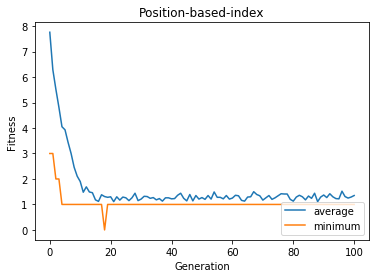

In [39]:
gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Position-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()



### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [20]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('Eval Fitness Value:',eval_fitness(best_ind))
show_grid(best_ind, board_size)


Best individual is: [60, 40, 17, 5, 38, 50, 15, 27]
[]
Eval Fitness Value: (0,)
-|-|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|-|X|-|-|-|
----------------


## Part II: Row-index-based board representation

In [41]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


C:\Users\Noah\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Noah\anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Each row of the chess row is indexed from 0->7 . we place different queens on different rows initially.  The sequence [ a b c d .... ] means that in $0^{th}$ row, $a^{th}$ column, the queen is present and so on

In [42]:
toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, 0, board_size-1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_int, n=board_size)

In [43]:
toolbox.individual()

[6, 4, 4, 2, 2, 2, 3, 5]

In [44]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [45]:
pop = toolbox.population(n=5)

print(pop[0])

[4, 0, 6, 0, 7, 5, 6, 3]


In [46]:
def show_grid(board, board_size):
    n = [0] * (board_size * board_size)
    for i in range(len(board)):
        n[board[i] + i * board_size] = 1
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X', end="|")
                else:
                    print('-', end="|")
        print()
        print("----------------")

In [47]:
show_grid(pop[0], board_size)

-|-|-|-|X|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|-|-|X|-|-|-|-|
----------------


### 10 pts:  Write your code in the cell below to define the "evaFitness" function, which return the fitness of any given board

- evaFitness() returns the total number of distinct pairs of queens that attack each other.  

- The following are some test cases you may use to verify the correctness of the evaFitness() function:

 * evaFitness([0, 2, 6, 7, 7, 4, 1, 6]) should return (4,)

 * evaFitness([7, 5, 2, 4, 3, 1, 3, 5]) should return (6,)

 * evaFitness([3, 1, 6, 0, 5, 7, 2, 1]) should return (5,)

 * evaFitness([7, 3, 1, 4, 5, 1, 3, 5]) should return (6,)



## compute_conflicts()
Computes the number of conflicts in a given board using a frequency list representation of the board in linear time row a row-index representation. Based on following method described in the following page: https://towardsdatascience.com/computing-number-of-conflicting-pairs-in-a-n-queen-board-in-linear-time-and-space-complexity-e9554c0e0645

In [48]:
def compute_conflicts(board, board_size):
    row = [0] * board_size
    diag_right = [0] * (2 * board_size)
    diag_left = [0] * (2 * board_size)
    
    for i in range(board_size):
        row[board[i]] += 1
        diag_right[board[i] + i] += 1
        diag_left[board_size - board[i] + i] += 1
    
    conflicts = 0
    for i in range(2 * board_size):
        if i < board_size:
            conflicts += (row[i] * (row[i] - 1)) / 2
        conflicts += (diag_right[i] * (diag_right[i] - 1)) / 2
        conflicts += (diag_left[i] * (diag_left[i] - 1)) / 2
    return int(conflicts) 

In [49]:
list1 = [0, 2, 6, 7, 7, 4, 1, 6]
list2 = [7, 5, 2, 4, 3, 1, 3, 5]
list3 = [3, 1, 6, 0, 5, 7, 2, 1]
list4 = [7, 3, 1, 4, 5, 1, 3, 5]

In [50]:
#fitness function
def eval_fitness(individual):
    conflict = compute_conflicts(individual, board_size)
    return (conflict, )

In [51]:
print(eval_fitness(list1))
print(eval_fitness(list2))
print(eval_fitness(list3))
print(eval_fitness(list4))

(4,)
(6,)
(5,)
(6,)


### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [52]:

toolbox.register("evaluate", eval_fitness)


In [53]:

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 7, indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)



In [54]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)


stats.register("avg", np.mean)
stats.register("min", np.min)



### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change. 

In [61]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

pop = toolbox.population(n=100)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)


gen	nevals	avg 	min
0  	100   	7.81	1  
1  	61    	6.59	2  
2  	59    	5.79	3  
3  	56    	5.29	3  
4  	55    	4.94	3  
5  	64    	4.63	3  
6  	52    	4.24	2  
7  	57    	3.84	2  
8  	65    	3.69	2  
9  	57    	3.24	2  
10 	58    	2.89	2  
11 	60    	2.67	2  
12 	64    	2.35	1  
13 	63    	2.38	1  
14 	70    	2.41	1  
15 	72    	2.24	1  
16 	64    	2.15	1  
17 	78    	1.73	1  
18 	61    	1.47	1  
19 	59    	1.17	0  
20 	56    	1.19	1  
21 	66    	1.16	1  
22 	47    	1.18	0  
23 	68    	1.13	0  
24 	78    	1.29	0  
25 	63    	1.29	0  
26 	62    	1.04	0  
27 	60    	0.58	0  
28 	56    	0.23	0  
29 	69    	0.21	0  
30 	57    	0.22	0  
31 	67    	0.36	0  
32 	54    	0.27	0  
33 	64    	0.34	0  
34 	60    	0.52	0  
35 	61    	0.37	0  
36 	49    	0.27	0  
37 	59    	0.36	0  
38 	55    	0.18	0  
39 	51    	0.34	0  
40 	63    	0.29	0  
41 	56    	0.37	0  
42 	63    	0.33	0  
43 	62    	0.33	0  
44 	52    	0.33	0  
45 	58    	0.25	0  
46 	61    	0.56	0  
47 	69    	0.23	0  
48 	54    	0.17	0  


### 5 pts:  Plot the "avg" and "min" for each generation

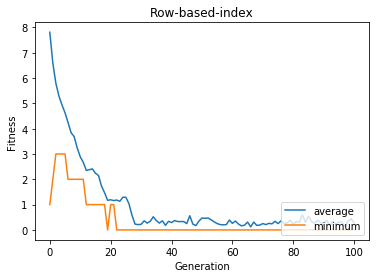

In [62]:
# Plot the "avg" and "min" for each generation

gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Row-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [63]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('Number of conflicts:',compute_conflicts(best_ind,board_size))
show_grid(best_ind, board_size)


Best individual is: [6, 1, 5, 2, 0, 3, 7, 4]
Number of conflicts: 0
-|-|-|-|-|-|X|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|X|-|-|-|
----------------


### Reflection:  Which board representaion is better in terms of ease of coding and final solution quality?   Try different parameter values for mutation and crossover and vary the number of generations and the population size.  Write your findings in the report.        

Ease of coding: 
    1D array method
    
Solution quality:
    Row-index representation